<a href="https://colab.research.google.com/github/santisis/frs22/blob/master/practico1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fundamentos del recurso solar 2022
Práctico 1 -- Radiación solar
=============================

Sebastián Santisi <ssantisi@csc.conicet.gov.ar>

In [44]:
from math import pi, exp, sin, cos, acos, asin, tan, atan2, radians, degrees, copysign, nan
import datetime

import pandas

import matplotlib.pyplot as plt
import matplotlib.patches

plt.rcParams['axes.grid'] = True
plt.rcParams['figure.figsize'] = figsize = (10, 5)

!wget --no-cache --backups=1 https://raw.githubusercontent.com/santisis/frs22/master/LB_2018_completo.csv
!wget --no-cache --backups=1 https://raw.githubusercontent.com/santisis/frs22/master/PX60_LE_RAD_2017.csv
!wget --no-cache --backups=1 https://raw.githubusercontent.com/santisis/frs22/master/AMTUes_v2-4_SAL_horario.csv
!wget --no-cache --backups=1 https://raw.githubusercontent.com/santisis/frs22/master/2013_SM.csv

--2022-04-27 03:56:26--  https://raw.githubusercontent.com/santisis/frs22/master/LB_2018_completo.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1010101 (986K) [text/plain]
Saving to: ‘LB_2018_completo.csv’

LB_2018_completo.cs 100%[===================>] 986.43K  --.-KB/s    in 0.05s   

2022-04-27 03:56:26 (19.9 MB/s) - ‘LB_2018_completo.csv’ saved [1010101/1010101]

--2022-04-27 03:56:26--  https://raw.githubusercontent.com/santisis/frs22/master/PX60_LE_RAD_2017.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 695532 (67

Ejercicio 0 -- Parte a
----------------------

Implementación:

In [45]:
GS = 1361 # W/m2
IS = 4.9  # MJ/m2

def factor_correccion_orbital(n):
  """Fn, órbita elíptica
  n es el día ordinal"""
  epsilon = 0.01671123
  phi = 2 * pi * n / 365

  return (1 + epsilon * cos(phi)) ** 2 / (1 - epsilon ** 2)

def factor_correccion_orbital_spencer(n):
  """Fn, por parametrización de Spencer
  n es el día ordinal"""
  gamma = 2 * pi * (n - 1) / 365
  return 1.000110 + 0.034221 * cos(gamma) + 0.001280 * sin(gamma) + \
    0.000719 * cos(2 * gamma) + 0.000077 * sin(2 * gamma)

def declinacion_solar(n):
  """$\delta$, parametrización de Cooper
  n es el día ordinal"""
  return 0.409 * sin(2 * pi * (284 + n) / 365)

def declinacion_solar_spencer(n):
  """$\delta$, parametrización de Spencer
  n es el día ordinal"""
  gamma = 2 * pi * (n - 1) / 365
  return 0.006918 - 0.399912 * cos(gamma) + 0.070257 * sin(gamma) - \
    0.006758 * cos(2 * gamma) + 0.000907 * sin(2 * gamma) - \
    0.002697 * cos(3 * gamma) + 0.00148 * sin(3 * gamma)

def angulo_cenital_minimo(n, latitud):
  """$\min\Theta_z$
  n es el día ordinal"""
  return abs(declinacion_solar_spencer(n) - latitud)

def altura_solar_maxima(n, latitud):
  """$\Max\alpha_s$"""
  return pi / 2 - angulo_cenital_minimo(n, latitud)

def angulo_horario_puesta_de_sol(n, latitud):
  """$\omega_s$"""
  return acos(-tan(declinacion_solar_spencer(n) * tan(latitud)))

def azimut_solar_puesta_de_sol(n, latitud):
  """$\gamma_s$"""
  #return asin(cos(declinacion_solar_spencer(n) * sin(angulo_horario_puesta_de_sol(n, latitud))))
  return abs(acos(sin(declinacion_solar_spencer(n) / cos(latitud))))

def ecuacion_del_tiempo_spencer(n):
  """$E$"""
  gamma = 2 * pi * (n - 1) / 365
  return 229.18 * (0.000075 + \
    0.001868 * cos(gamma) - 0.032077 * sin(gamma) - \
    0.014615 * cos(2 * gamma) - 0.04089 * sin(2 * gamma))

def duracion_del_dia(n, latitud):
  """$N_0$"""
  return 24 / pi * angulo_horario_puesta_de_sol(n, latitud)

def irradiacion_diaria_TOA_normal(n):
  """$H_0$"""
  return IS * factor_correccion_orbital_spencer(n) * 12 # En la normal el día siempre dura 12 horas, ¿no?

def irradiacion_diaria_TOA_horizontal(n, latitud):
  """$H_{0h}$"""
  fn = factor_correccion_orbital_spencer(n)
  delta = declinacion_solar_spencer(n)
  omegas = angulo_horario_puesta_de_sol(n, latitud)
  return 24 / pi * IS * fn * (cos(delta) * cos(latitud) * sin(omegas) + omegas * sin(delta) * sin(latitud))

Pruebas:

**Observación:** La gráfica de duración del día es muy similar a la de las diapositivas del curso pero no es idéntica. No se puede alcanzar el valor de -66 del círculo polar porque ya mucho antes se alcanzan valores que corresponden a valores fuera de rango del acos.

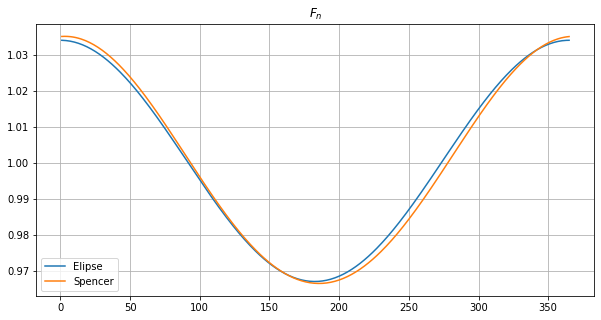

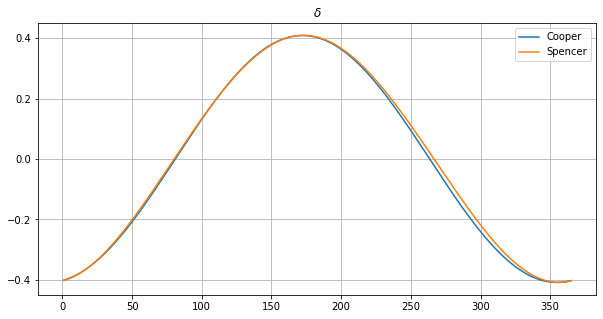

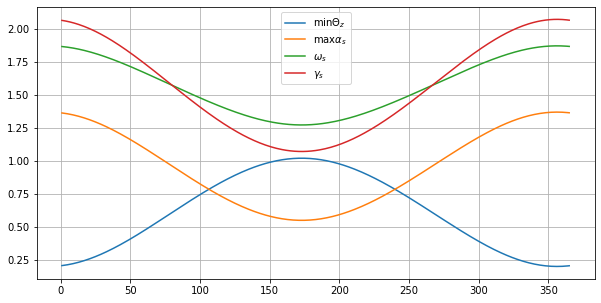

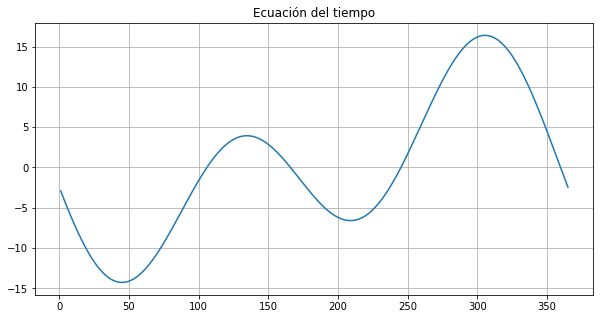

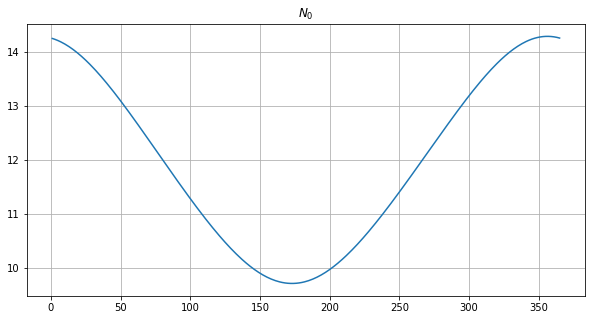

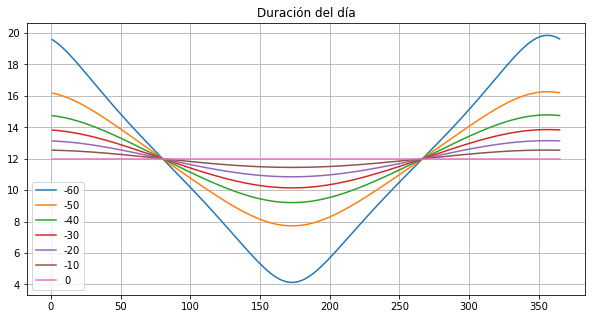

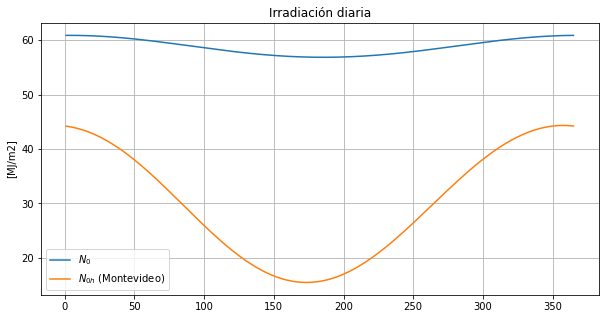

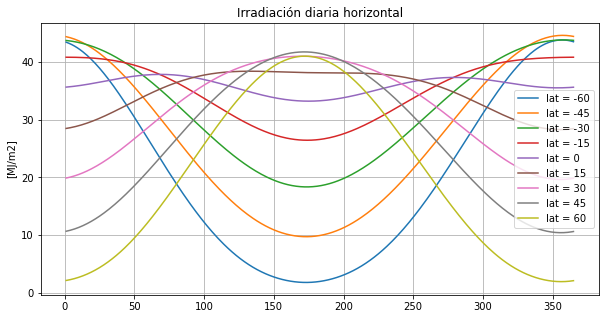

In [46]:
ns = list(range(1, 366)) # ¿Deberíamos haber usado NumPy?... ¡nah!
latitud = radians(-35)  # Tomamos Montevideo, como en las diapositivas.
longitud = radians(-56.2)
huso = -3

plt.plot(ns, [factor_correccion_orbital(n) for n in ns], label='Elipse')
plt.plot(ns, [factor_correccion_orbital_spencer(n) for n in ns], label='Spencer')
plt.legend()
plt.title('$F_n$')
plt.show()

plt.plot(ns, [declinacion_solar(n) for n in ns], label='Cooper')
plt.plot(ns, [declinacion_solar_spencer(n) for n in ns], label='Spencer')
plt.legend()
plt.title('$\delta$')
plt.show()

plt.plot(ns, [angulo_cenital_minimo(n, latitud) for n in ns], label='$\min\Theta_z$')
plt.plot(ns, [altura_solar_maxima(n, latitud) for n in ns], label='$\max\\alpha_s$')
plt.plot(ns, [angulo_horario_puesta_de_sol(n, latitud) for n in ns], label='$\omega_s$')
plt.plot(ns, [azimut_solar_puesta_de_sol(n, latitud) for n in ns], label='$\gamma_s$')
plt.legend()
plt.show()

plt.plot(ns, [ecuacion_del_tiempo_spencer(n) for n in ns])
plt.title('Ecuación del tiempo')
plt.show()

plt.plot(ns, [duracion_del_dia(n, latitud) for n in ns])
plt.title('$N_0$')
plt.show()

for lat in range(-60, 1, 10):
  plt.plot(ns, [duracion_del_dia(n, radians(lat)) for n in ns], label='%d' % lat)
plt.title('Duración del día')
plt.legend()
plt.show()

plt.plot(ns, [irradiacion_diaria_TOA_normal(n) for n in ns], label='$N_0$')
plt.plot(ns, [irradiacion_diaria_TOA_horizontal(n, latitud) for n in ns], label='$N_{0h}$ (Montevideo)')
plt.title('Irradiación diaria')
plt.ylabel('[MJ/m2]')
plt.legend()
plt.show()

for lat in range(-60, 61, 15):
  plt.plot(ns, [irradiacion_diaria_TOA_horizontal(n, radians(lat)) for n in ns], label='lat = %d' % lat)
plt.title('Irradiación diaria horizontal')
plt.ylabel('[MJ/m2]')
plt.legend()
plt.show()

Ejercicio 0 -- Parte b
----------------------

In [47]:
def angulo_cenital(n, omega, latitud):
  delta = declinacion_solar_spencer(n)
  return acos(sin(delta) * sin(latitud) + cos(delta) * cos(latitud) * cos(omega))

def altura_solar(n, omega, latitud):
  return pi / 2 - angulo_cenital(n, omega, latitud)

def sign(x):
  return copysign(1, x)

def angulo_acimutal(n, omega, latitud):
  delta = declinacion_solar_spencer(n)
  thetaz = angulo_cenital(n, omega, latitud)
  arg = (sin(delta) - cos(thetaz) * sin(latitud)) / (sin(thetaz) * cos(latitud))
  if(arg < -1): return -pi
  if(arg > 1): return 0
  return sign(omega) * abs(acos(arg))

def tiempo_estandar(n, omega, longitud, huso):
  return 12 * (1 + omega / pi) - degrees(longitud) / 15 + huso - ecuacion_del_tiempo_spencer(n) / 60

Equinoccio: [(80, -0.001150591501957688), (81, 0.005740992150424236)]
Solsticio: [(172, 0.40931542032971796), (173, 0.4093769016352889), (174, 0.4093177443428098)]
Equinoccio: [(266, 0.004342022176745865), (267, -0.0024503120898228025)]
Solsticio: [(355, -0.40875419804612767), (356, -0.40886151186277603), (357, -0.4088324041724486)]


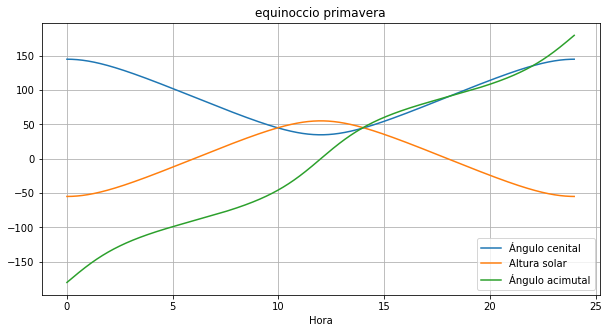

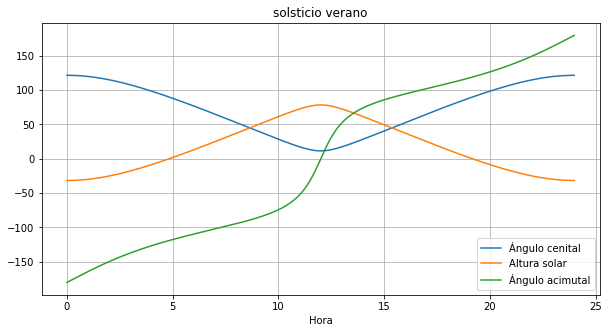

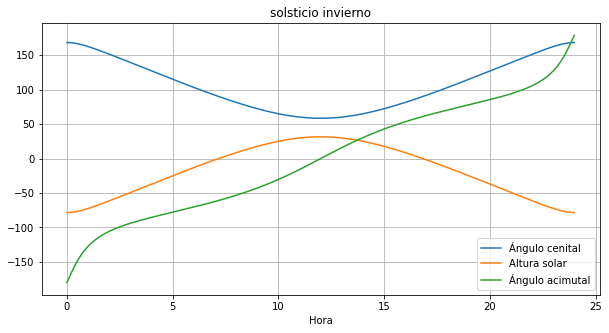

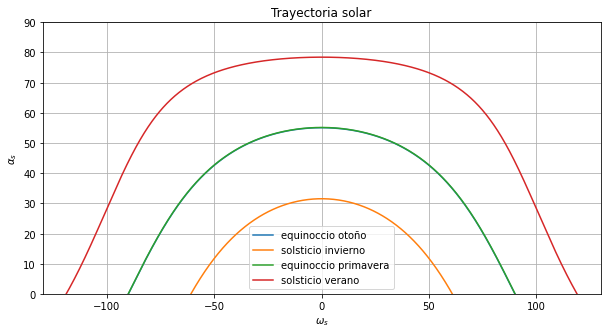

Mediodía en equinoccio otoño: 12:52:39
Mediodía en solsticio invierno: 12:46:20
Mediodía en equinoccio primavera: 12:36:47
Mediodía en solsticio verano: 12:43:05


In [48]:
hs = [m / 60 for m in range(60 * 24)]
omegas = [(h - 12) * pi / 12 for h in hs]

deltas = [(n, declinacion_solar_spencer(n)) for n in ns]
print('Equinoccio:', deltas[79:81])
print('Solsticio:', deltas[171:174])
print('Equinoccio:', deltas[265:267])
print('Solsticio:', deltas[354:357])

nsolsticios = {
    'equinoccio otoño': 80,
    'solsticio invierno': 173,
    'equinoccio primavera': 267,
    'solsticio verano': 356,
}

for k in ('equinoccio primavera', 'solsticio verano', 'solsticio invierno'):
  n = nsolsticios[k]
  plt.plot(hs, [degrees(angulo_cenital(n, omega, latitud)) for omega in omegas], label='Ángulo cenital')
  plt.plot(hs, [degrees(altura_solar(n, omega, latitud)) for omega in omegas], label='Altura solar')
  plt.plot(hs, [degrees(angulo_acimutal(n, omega, latitud)) for omega in omegas], label='Ángulo acimutal')
  plt.title(k)
  plt.xlabel("Hora")
  plt.legend()
  plt.show()

for nombre,n in nsolsticios.items():
  plt.plot(
      [degrees(angulo_acimutal(n, omega, latitud)) for omega in omegas],
      [degrees(altura_solar(n, omega, latitud)) for omega in omegas],
      label=nombre
      )
plt.axis([-130, 130, 0, 90])
plt.legend()
plt.title("Trayectoria solar")
plt.xlabel(r"$\omega_s$")
plt.ylabel(r"$\alpha_s$")
plt.show()

def tiempo_a_hms(t):
  h = int(t)
  m = (t - h) * 60
  s = int((m - int(m)) * 60)
  m = int(m)
  return h, m, s

for nombre,n in nsolsticios.items():
  tutc = tiempo_estandar(n, 0, longitud, huso)
  print('Mediodía en %s: %02d:%02d:%02d' % ((nombre, ) + tiempo_a_hms(tutc)))

Ejercicio 1
-----------

**Parte b**

(Varias de las cosas pedidas en este ejercicio ya están como parte de las pruebas del ejercicio 0.)

* Visualización: Pruebas 0-a.
* Días más corto y más largo:

Si consideramos horas de sol son los solsticios: n = 173, 356.

Si consideramos duración son los máximos y mínimos de la ecuación de tiempo:


In [49]:
es = [ecuacion_del_tiempo_spencer(n) for n in ns]
print('Mínimo: E(%d) = %f' % (es.index(min(es)) + 1, min(es))) # El +1 es porque los ns están en rango 1..365 y los índices en rango 0..364
print('Máximo: E(%d) = %f' % (es.index(max(es)) + 1, max(es)))

print('Duración mínima: %02d:%02d:%02d' % tiempo_a_hms(24 + min(es) / 60))
print('Duración máxima: %02d:%02d:%02d' % tiempo_a_hms(24 + max(es) / 60))

Mínimo: E(45) = -14.266350
Máximo: E(306) = 16.387239
Duración mínima: 23:45:44
Duración máxima: 24:16:23


* Irradiaciones máximas:

In [50]:
print('Irradiación máxima diaria TOA en Montevideo: %f MJ/m2' % max([irradiacion_diaria_TOA_horizontal(n, latitud) for n in ns]))
print('Irradiación máxima diaria TOA en lat +35: %f MJ/m2' % max([irradiacion_diaria_TOA_horizontal(n, -latitud) for n in ns]))

Irradiación máxima diaria TOA en Montevideo: 44.321566 MJ/m2
Irradiación máxima diaria TOA en lat +35: 41.465539 MJ/m2


Se observa que el $F_n$ es máximo durante el solsticio de verano austral y mínimo en el solsticio de verano boreal con una diferencia del orden del 7%, eso explicaría la diferencia.

**Parte b**

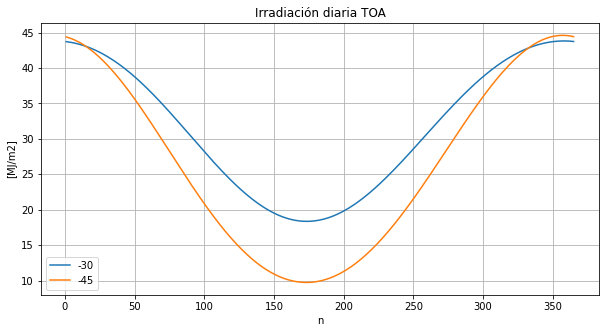

Duración máxima del día -30: 13.8557951299093
Duración máxima del día -45: 15.423438827920874


In [51]:
plt.plot(ns, [irradiacion_diaria_TOA_horizontal(n, radians(-30)) for n in ns], label='-30')
plt.plot(ns, [irradiacion_diaria_TOA_horizontal(n, radians(-45)) for n in ns], label='-45')
plt.title('Irradiación diaria TOA')
plt.ylabel('[MJ/m2]')
plt.xlabel('n')
plt.legend()
plt.show()

print('Duración máxima del día -30:', max([duracion_del_dia(n, radians(-30)) for n in ns]))
print('Duración máxima del día -45:', max([duracion_del_dia(n, radians(-45)) for n in ns]))

Se cree que la mayor radiación recibida en el solsticio de verano se corresponde con la duración del día que es de casi 2 horas adicionales y compensa el menor ángulo de elevación solar.

**Parte c**

In [52]:
departamentos = {
    'Rocha': (-33.74, -53.37),
    'Trenta y Tres': (-32.83, -53.29),
    'Cerro Largo': (-32.71, -53.18)
}

for nombre,coordenadas in departamentos.items():
  lat, lon = (radians(x) for x in coordenadas)
  omegaamanecer = [(n, -angulo_horario_puesta_de_sol(n, lat)) for n in ns]
  tiempoamanecer = [tiempo_estandar(n, omega, lon, huso) for (n, omega) in omegaamanecer]
  print('En %s amanece a las %02d:%02d:%02d' % ((nombre, ) + tiempo_a_hms(min(tiempoamanecer))))

En Rocha amanece a las 05:22:39
En Trenta y Tres amanece a las 05:24:34
En Cerro Largo amanece a las 05:24:24


Se buscó el valor del amanecer en hora local más temprano del año para cada sitio.

Para sorpresa de nadie, amanece antes en el sitio más al este.

Cabe destacar que el menor ángulo horario se da el 31/12, no sé si no hay algún error en cómo lo comprobé.

Ejercicio 2
-----------

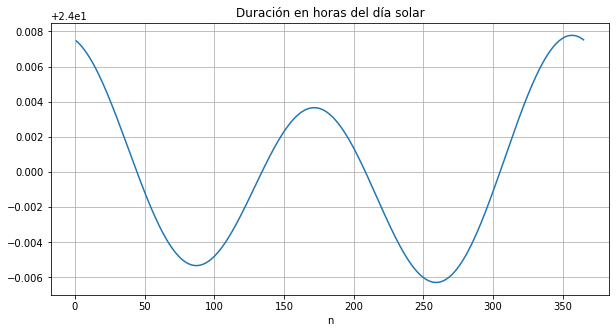

In [53]:
mediodias = [tiempo_estandar(n, 0, longitud, huso) for n in ns]
duraciones = []
for i in range(len(mediodias)):
  duraciones.append(mediodias[(i + 1) % len(mediodias)] - mediodias[i] + 24)

plt.plot(ns, duraciones)
plt.title('Duración en horas del día solar')
plt.xlabel('n')
plt.show()


Puede verse que como lo que se comparan son las horas entre los mediodías solares de dos días consecutivos termina siendo la derivada de la ecuación del tiempo $E$.

Los días que duran exactamente 24 horas se corresponden con los máximos y mínimos de $E$, que es cuando la corrección con respecto a la cantidad de horas es la misma en dos días consecutivos.

Ejercicio 3
-----------

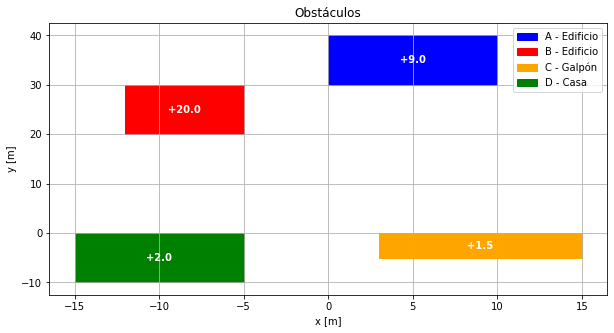

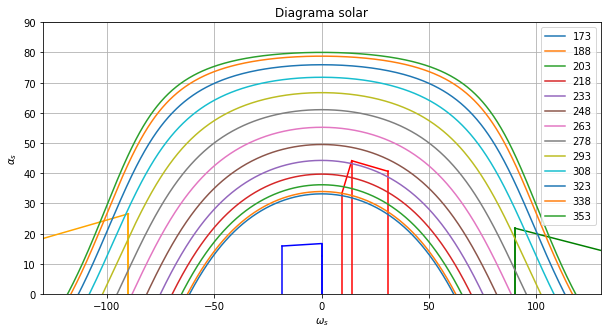

In [54]:
lat = radians(-33.382)
lon = radians(-56.523)

obstaculos = {
    'A - Edificio': (0, 30, 10, 40, 9, 'blue'),
    'B - Edificio': (-5, 20, -12, 30, 20, 'red'),
    'C - Galpón': (3, 0, 15, -5, 1.5, 'orange'),
    'D - Casa': (-5, 0, -15, -10, 2, 'green'),
}

fig = plt.figure()
ax = fig.add_subplot(111)

for k,v in obstaculos.items():
  x0, y0, x1, y1, z, c = v
  ax.add_patch(matplotlib.patches.Rectangle((x0, y0), x1 - x0, y1 - y0, color=c, label=k))
  plt.text((x0 + x1) / 2, (y0 + y1) / 2, '+%.1f' % z, color='white', fontweight='bold', horizontalalignment='center', verticalalignment='center')

plt.title('Obstáculos')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.legend()
plt.plot()
plt.show()


for k,v in obstaculos.items():
  x0, y0, x1, y1, z, c = v
  ps = []

  for x,y in ((x1, y0), (x0, y0), (x0, y1)):
    d = (x ** 2 + y ** 2) ** .5
    omega = degrees(atan2(-x, y)) # Invierto x e y pero es correcto, -x por convención este-oeste
    alpha = degrees(atan2(z, d))
    ps.append((omega, alpha))

  p0, p1, p2 = ps
  plt.plot((p0[0], p0[0]), (0, p0[1]), color=c)
  plt.plot((p1[0], p1[0]), (0, p1[1]), color=c)
  plt.plot((p2[0], p2[0]), (0, p2[1]), color=c)
  plt.plot((p0[0], p1[0]), (p0[1], p1[1]), color=c)
  plt.plot((p1[0], p2[0]), (p1[1], p2[1]), color=c)


for n in range(nsolsticios['solsticio invierno'], nsolsticios['solsticio verano'], 15):
  plt.plot(
      [degrees(angulo_acimutal(n, omega, lat)) for omega in omegas],
      [degrees(altura_solar(n, omega, lat)) for omega in omegas],
      label='%d' % n
      )
plt.axis([-130, 130, 0, 90])
plt.title('Diagrama solar')
plt.xlabel(r'$\omega_s$')
plt.ylabel(r'$\alpha_s$')
plt.legend()
plt.show()

En principio los obstáculos más preocupantes van a ser siempre los que estén al norte y cercanos. Los objetos que se ecuentran al sur sólo van a hacer sombra en los amaneceres/atardeceres del verano. En cuanto a los objetos al norte importa la altura y la distancia; objetos o bajos o a larga distancia no van a hacer sombra dado que incluso en el invierno el sol les pasará por arriba.

En este caso puede verse que el edificio de 9 metros de altura que se encuentra a 30 metros no hace sombra en ningún momento del año. Incluso aunque tuviera el doble de esa altura no lo haría.

En cambio el de 20 metros ubicado a poco más de 20 metros hace sombra aproximadamente 120 días al año (aproximadamente 60 días después del solsticio según el gráfico). El edificio este tiene de ancho 16 grados entre sus dos lados, por lo que la sombra será aproximadamente 1 hora al día.

Ejercicio 4
-----------

In [55]:
def inversa_tiempo_estandar(n, tutc, longitud, huso):
  return pi * ((tutc + ecuacion_del_tiempo_spencer(n) / 60 - huso + degrees(longitud) / 15) / 12 - 1)

assert(inversa_tiempo_estandar(100, tiempo_estandar(100, 0, longitud, huso), longitud, huso) == 0)

count    8.376000e+03
mean    -7.523605e-07
std      4.199722e-05
min     -6.786757e-05
25%     -4.074599e-05
50%     -8.610933e-07
75%      3.900785e-05
max      6.784389e-05
Name: error_cz, dtype: float64


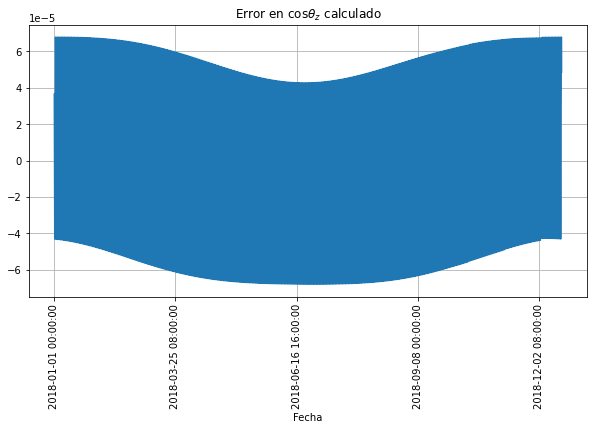

In [56]:
lblat = radians(-34.67)
lblon = radians(-56.34)

lb = pandas.read_csv('LB_2018_completo.csv', index_col='Fecha')

#print(lb.describe())

def computar_cz(row):
  n = row['N']
  nr = row['NR']
  omega = inversa_tiempo_estandar(n, nr - 0.5, lblon, huso)
  return cos(angulo_cenital(n, omega, lblat))

lb['cz_computado'] = lb.apply(computar_cz, axis=1)
lb['error_cz'] = lb['CZ'] - lb['cz_computado']

print(lb['error_cz'].describe())
lb['error_cz'].plot()
plt.title('Error en $\cos\\theta_z$ calculado')
plt.xticks(rotation = 90)
plt.show()
  

Las diferencias entre el $\cos\theta_z$ del CSV versus el calculado son ínfimas.

**Observación:** Se restaron 30 minutos a las etiquetas temporales cuando el enunciado decía que las mismas estaban al inicio, esto correspondería para etiquetas al final.

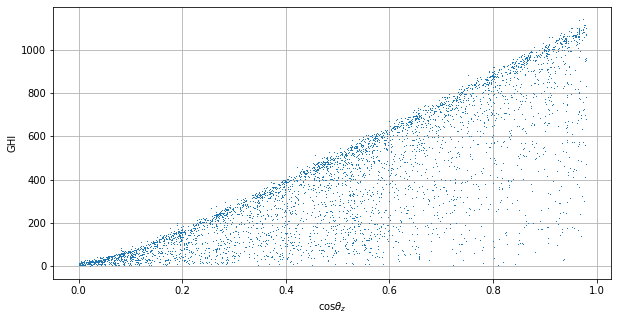

In [57]:
lbdiurnas = lb[lb['CZ'] > 0]
plt.plot(lbdiurnas['CZ'], lbdiurnas['GHI1'], ',')
plt.ylabel('GHI')
plt.xlabel('$\cos\\theta_z$')
plt.show()


El gráfico muestra una buena consistencia entre el CZ y el desplazamiento solar y valores esperables.

Modelo de cielo claro:

In [58]:
TL_SUR = [3.037, 2.964, 2.839, 2.659, 2.568, 2.434, 2.45, 2.56, 2.722, 2.729, 2.908, 2.963]

# Uso regla de Horner para evitar potencias en los polinomios, perdón.

def masa_de_aire(cz):
  """Fórmula de Young"""
  return ((1.002432 * cz + 0.148386) * cz + 0.0096467) / \
    (((cz + 0.149864) * cz + 0.0102963) * cz + 0.000303978)

def inv_kr(m):
  if m > 20:
    return 10.6 + 0.718 * m

  return (((-0.00013 * m + 0.00650) * m -0.12020) * m + 1.75130) * m + 6.62960

def irradiancia_TOA(n):
  """$G_0$"""
  return GS * factor_correccion_orbital_spencer(n)

def irradiancia_directa_superficie_horizontal(n, cz, tl):
  """$G_{bh,c}$"""
  m = masa_de_aire(cz)
  return irradiancia_TOA(n) * cz * exp(-m * tl / inv_kr(m))

def factor_transmitancia_difusa(tl):
  """$T_z(T_L)$"""
  return (3.797e-4 * tl + 3.0543e-2) * tl - 1.5843e-2

def modificador_angular_difusa(cz, tl):
  """$F_d(\theta_z, T_L)$"""
  a0 = (3.1408e-3 * tl - 6.1581e-2) * tl + 2.6463e-1
  a1 = (-1.1161e-2 * tl + 1.8945e-2) * tl + 2.0402
  a2 = (8.5079e-3 * tl + 3.9231e-2) * tl - 1.3025

  return (a2 * cz + a1) * cz + a0

def irradiancia_difusa_ESRA(n, cz, tl):
  tl = tl / 0.8665
  return irradiancia_TOA(n) * factor_transmitancia_difusa(tl) * modificador_angular_difusa(cz, tl)

def ghi_cielo_claro(n, cz, tl):
  if cz < 0: return 0
  return irradiancia_directa_superficie_horizontal(n, cz, tl) + irradiancia_difusa_ESRA(n, cz, tl)

Validación parámetros del modelo de cielo claro:

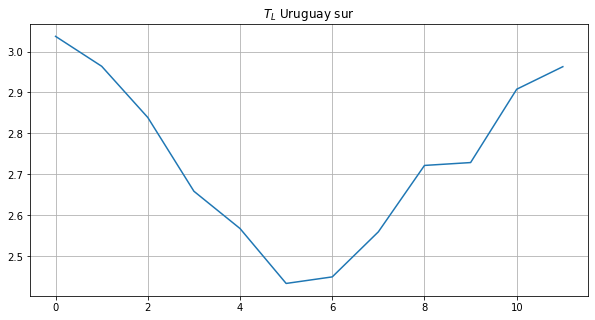

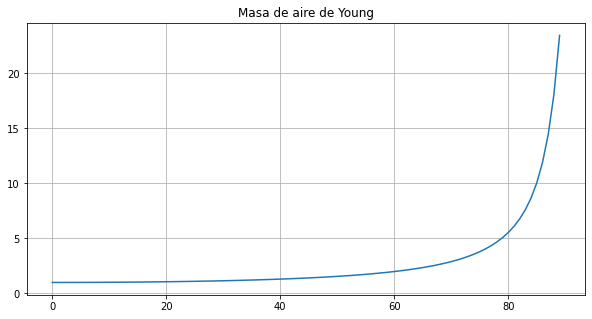

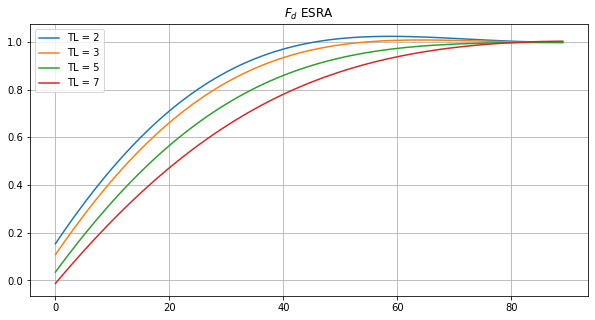

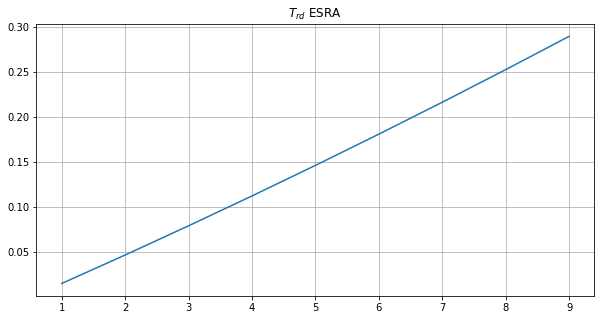

In [59]:
plt.plot(TL_SUR)
plt.title('$T_L$ Uruguay sur')
plt.show()

zs = range(90)
plt.plot(zs, [masa_de_aire(cos(radians(z))) for z in zs])
plt.title('Masa de aire de Young')
plt.show()

for tl in (2, 3, 5, 7):
  plt.plot(zs, [modificador_angular_difusa(cos(radians(90-z)), tl) for z in zs], label='TL = %d' % tl)
plt.legend()
plt.title('$F_d$ ESRA')
plt.show()

tls = range(1, 10)
plt.plot(tls, [factor_transmitancia_difusa(tl) for tl in tls])
plt.title('$T_{rd}$ ESRA')
plt.show()

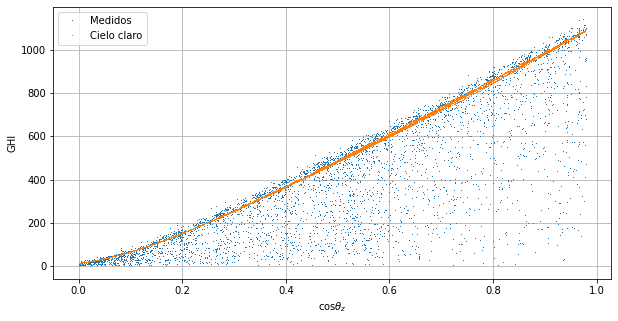

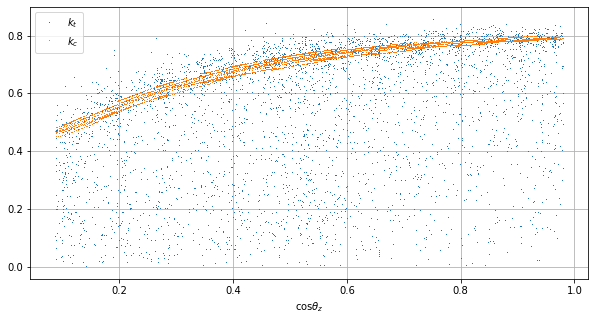

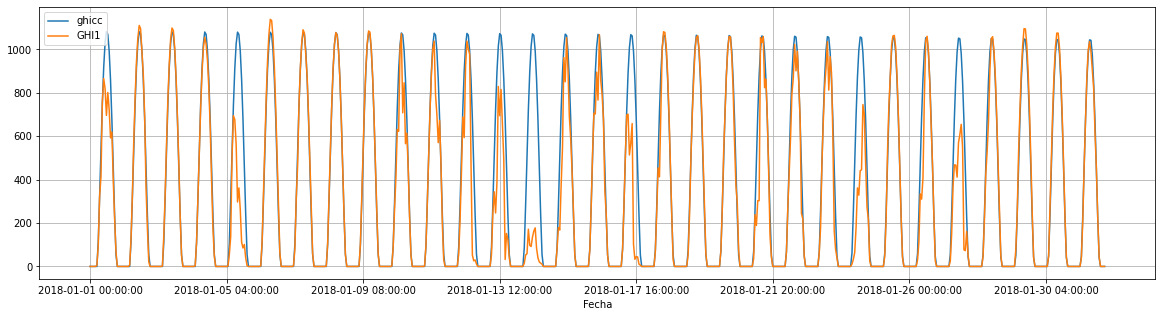

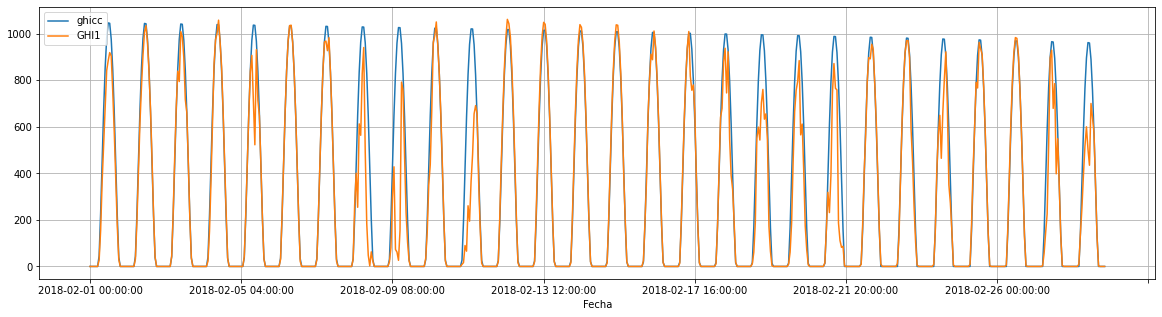

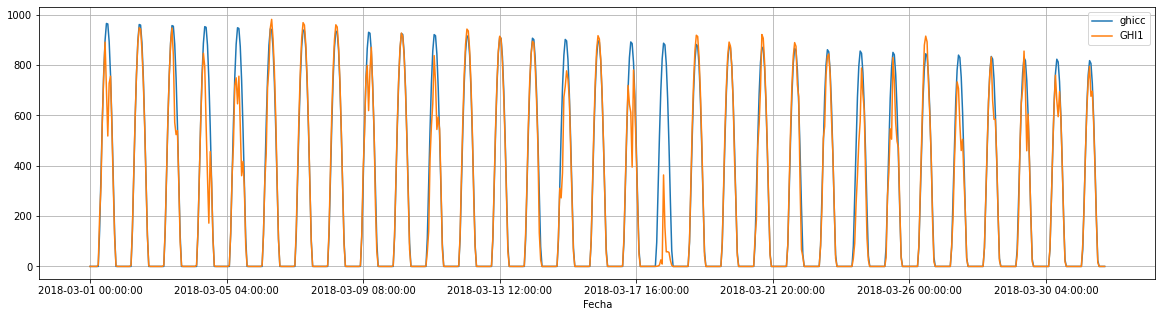

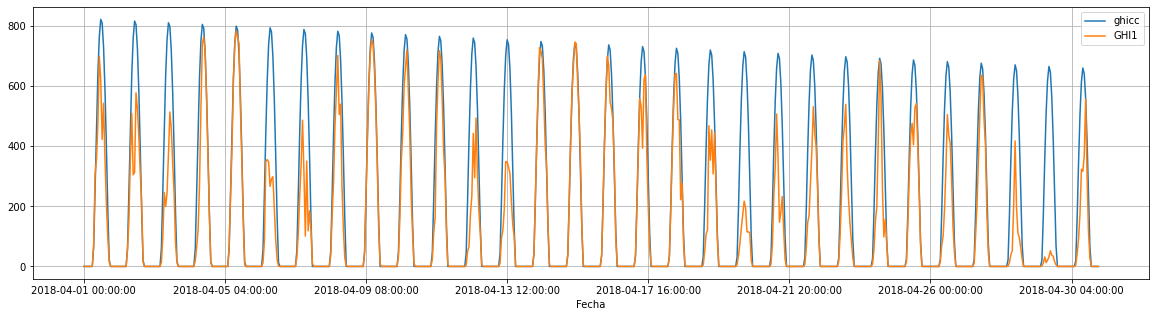

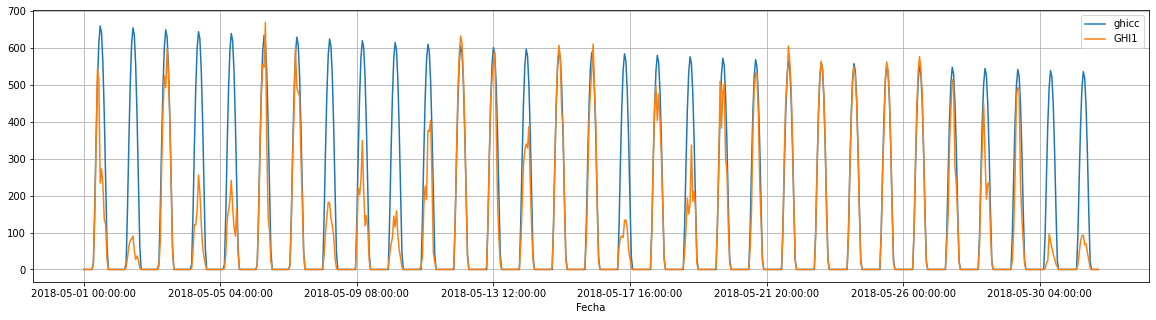

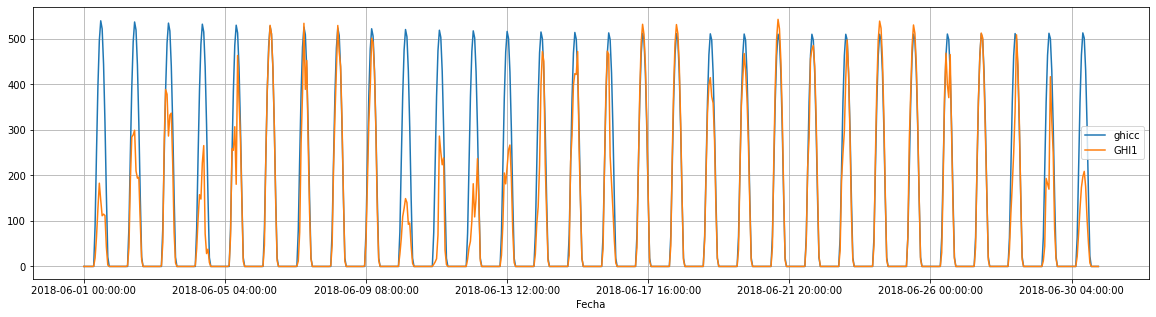

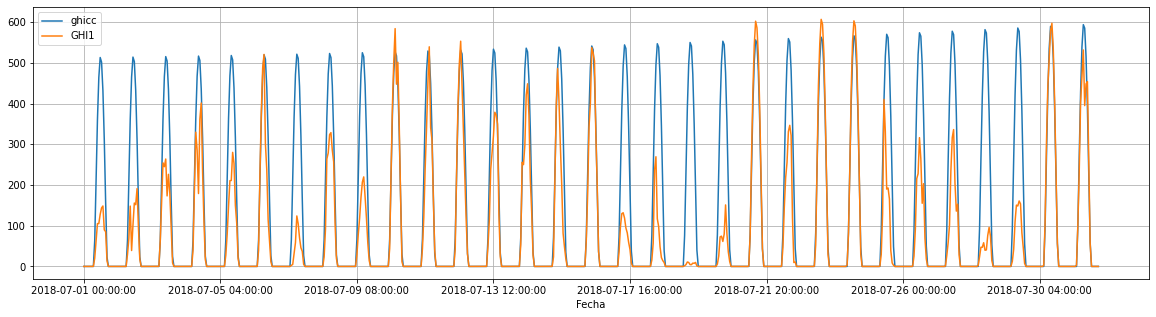

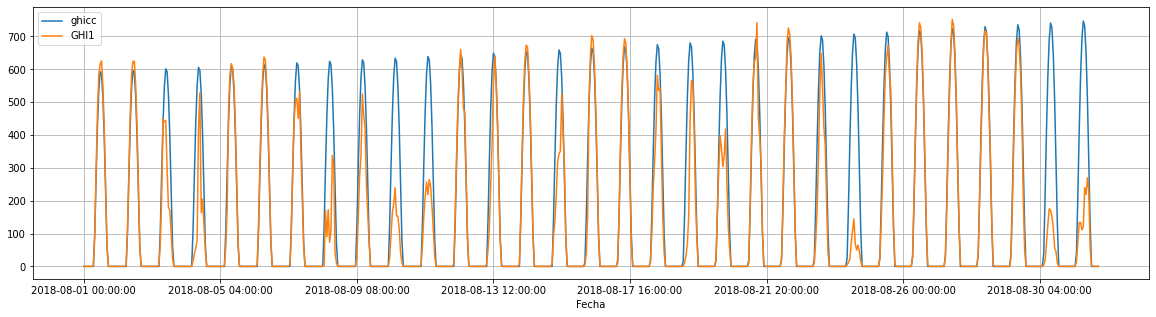

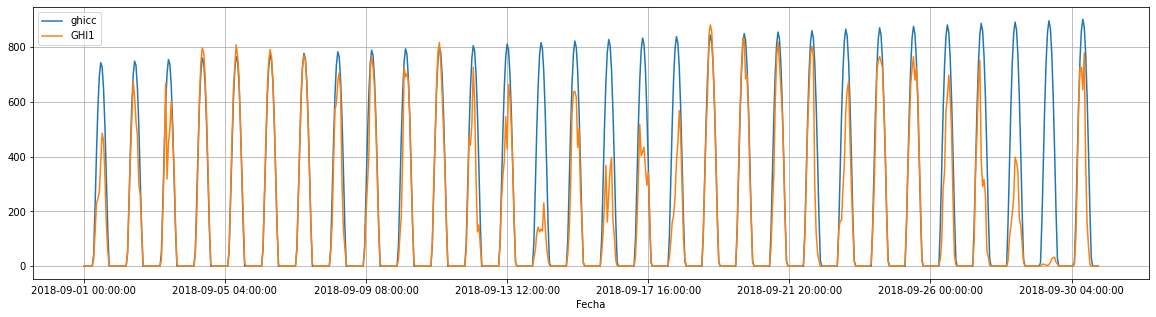

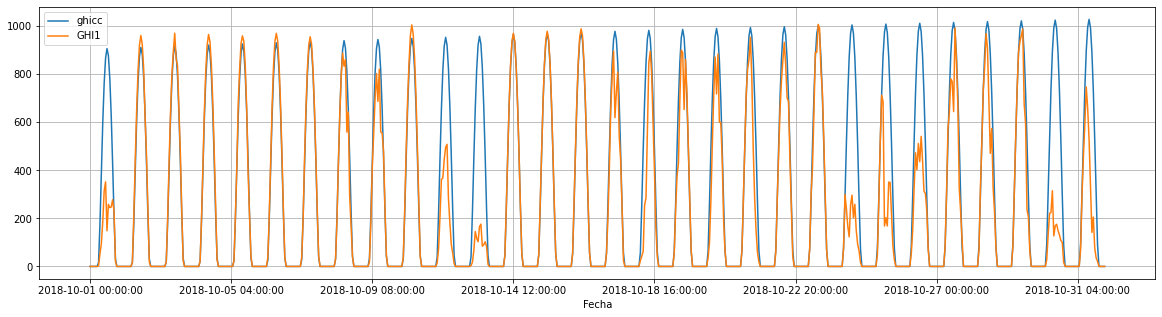

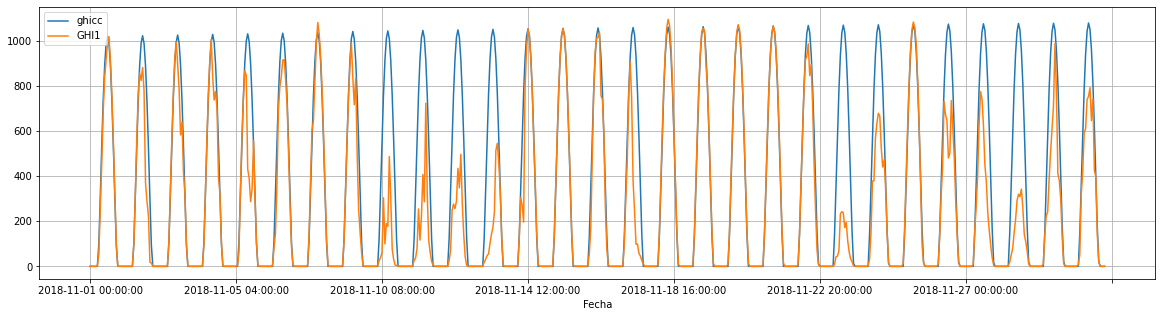

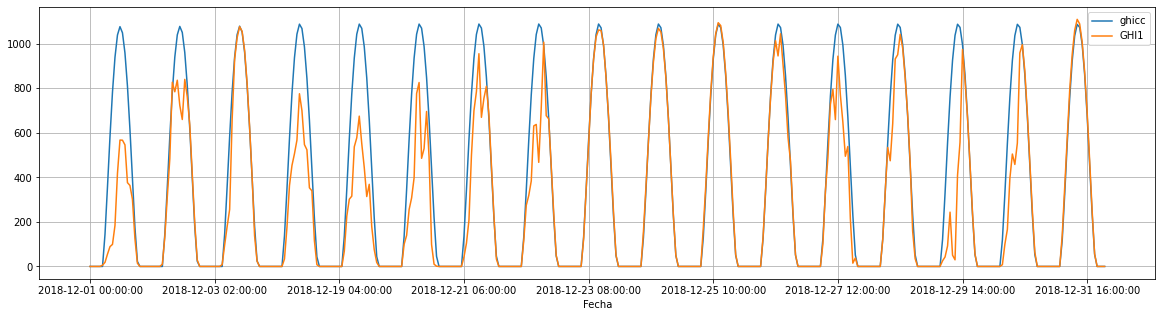

In [60]:
def computar_ghi(row):
  n = row['N']
  cz = row['CZ']
  tl = TL_SUR[int(row['Fecha.1'][5:7]) - 1] # Extraemos el mes
  return ghi_cielo_claro(n, cz, tl)


lb['ghicc'] = lb.apply(computar_ghi, axis=1)
lbdiurnas = lb[lb['CZ'] > 0]

plt.plot(lbdiurnas['CZ'], lbdiurnas['GHI1'], ',', label='Medidos')
plt.plot(lbdiurnas['CZ'], lbdiurnas['ghicc'], ',', label='Cielo claro')
plt.ylabel('GHI')
plt.xlabel('$\cos\\theta_z$')
plt.legend()
plt.show()

lb['goh'] = lb['N'].apply(irradiancia_TOA) * lb['CZ']
lb['kt'] = lb['GHI1'] / lb['goh']

lb['kc'] = lb['ghicc'] / lb['goh']

lbmayor5 = lb[lb['CZ'] > sin(radians(5))]
plt.plot(lbmayor5['CZ'], lbmayor5['kt'], ',', label='$k_t$')
plt.plot(lbmayor5['CZ'], lbmayor5['kc'], ',', label='$k_c$')
plt.legend()
plt.xlabel('$\cos\\theta_z$')
plt.show()

plt.rcParams['figure.figsize'] = (20, 5)
for mes in range(1, 13):
  # Llegado a este punto es donde me pregunto por qué no importé las fechas como datetime...
  lb['ghicc']['2018-%02d-01' % mes:'2018-%02d-01' % (mes + 1)].plot()
  lb['GHI1']['2018-%02d-01' % mes:'2018-%02d-01' % (mes + 1)].plot()
  plt.legend()
  plt.show()
plt.rcParams['figure.figsize'] = figsize

En la gráfica de $\mathrm{GHI}_{cc}$ y GHI versus $k_t$ se observa una tendencia del modelo de cielo claro a subestimar el valor de la irradiancia.

Podemos elegir el día 23/12, el 21/06 y el 2/10 como días completamente despejados lo más cercanos al solsticio de verano, invierno y al equinoccio de primavera respectivamente.

Cabe destacar que los días de primavera vienen complicados en la serie dada, incluso el día elegido parece tener una ligera baja en la GHI a las 15:00 hs.

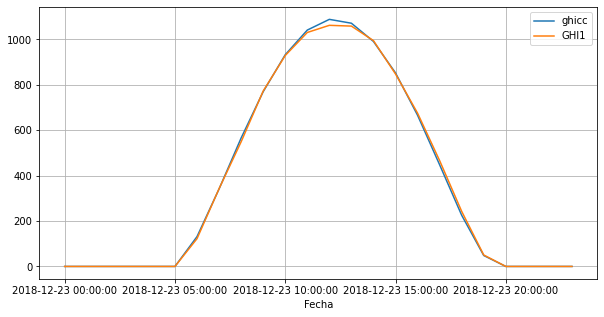

MBD: 2.373725
RMSD: 12.701860


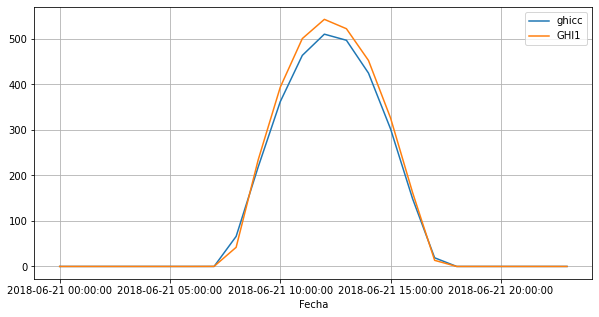

MBD: -20.389035
RMSD: 26.717319


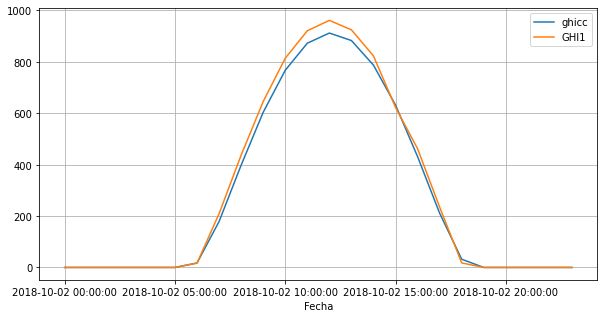

MBD: -34.436566
RMSD: 37.857421


In [61]:
nverano = lb['N']['2018-12-23 12:00:00']
ninvierno = lb['N']['2018-06-21 12:00:00']
nprimavera = lb['N']['2018-10-02 12:00:00']

for n in (nverano, ninvierno, nprimavera):
  dia = lb[lb['N'] == n]
  dia['ghicc'].plot()
  dia['GHI1'].plot()
  plt.legend()
  plt.show()

  dia = dia[dia['CZ'] > sin(radians(5))]
  err = dia['ghicc'] - dia['GHI1']

  # Estos estadísticos ya vienen en Pandas, pero los implemento según la ecuación
  print('MBD: %f' % (sum(err) / len(err)))
  print('RMSD: %f' % ((sum(err.apply(lambda x: x ** 2)) / len(err)) ** .5))

Ejercicio 5
-----------

In [62]:
salat = radians(-31.28)
salon = radians(-57.92)

def parse_date(s):                                                              
  return datetime.datetime.strptime(s, '%Y-%m-%d %H:%M:%S')

# Este archivo es sólo una concatenación de los 365 archivos dados, eliminando los encabezados repetidos
sa = pandas.read_csv('PX60_LE_RAD_2017.csv', index_col='Fecha', converters={'Fecha': parse_date})

# Construimos la columna N que viene en NA
sa['N'] = sa.index.to_series().apply(lambda x: x.timetuple().tm_yday)
# y agregamos NR centrando en el tiempo (esto lo validamos contra el CZ)
sa['NR'] = sa.index.to_series().apply(lambda x: x.hour) + 0.5

# Agregamos el TL desde la serie de TL_SUR
sa['TL'] = sa.index.to_series().apply(lambda x: TL_SUR[x.month - 1])

# Definitivamente era mejor trabajar con índices datetime...

sa['fd'] = sa.apply(lambda x: x['DHI'] / x['GHI'], axis=1)

sa['goh'] = sa['N'].apply(irradiancia_TOA) * sa['CZ']
sa['kt'] = sa['GHI'] / sa['goh']

sacorrectos = sa[(sa['CZ'] > 0.12) & (sa['DHI'] > 0) & (sa['DNI'] > 0) & (sa['GHI'] > 0) & (sa['fd'] < 1.05)]

# Hacemos esto para poder graficarlos y que se vean los baches:
saerroneosnan = sa.copy()
saerroneosnan[~((sa['CZ'] > 0.12) & (sa['DHI'] > 0) & (sa['DNI'] > 0) & (sa['GHI'] > 0) & (sa['fd'] < 1.05))] = nan
saerroneosnan['originales'] = sa['GHI']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


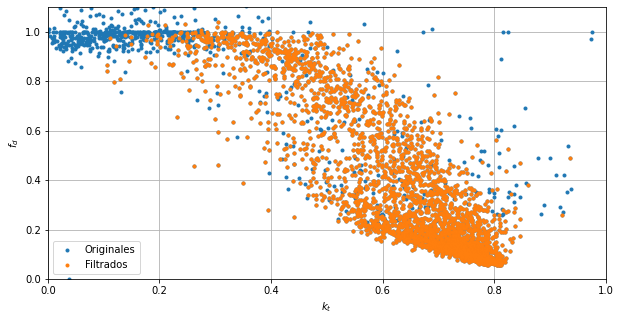

In [63]:
# Graficamos kt versus fd para ver qué filtramos y verificar ambas variables dado que son calculadas
plt.plot(sa['kt'], sa['fd'], '.', label='Originales')
plt.plot(sacorrectos['kt'], sacorrectos['fd'], '.', label='Filtrados')
plt.axis([0, 1, 0, 1.1])
plt.legend()
plt.xlabel('$k_t$')
plt.ylabel('$f_d$')
plt.show()

Para inspeccionar la calidad empezamos primero mirando los valores registrados:

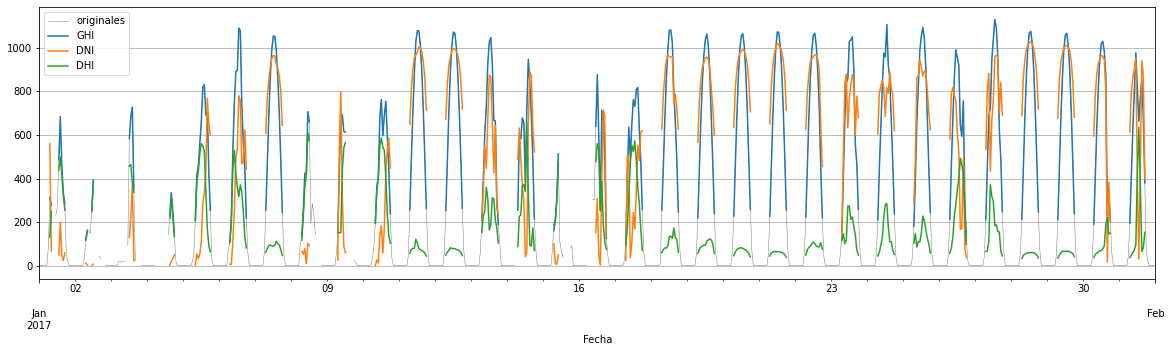

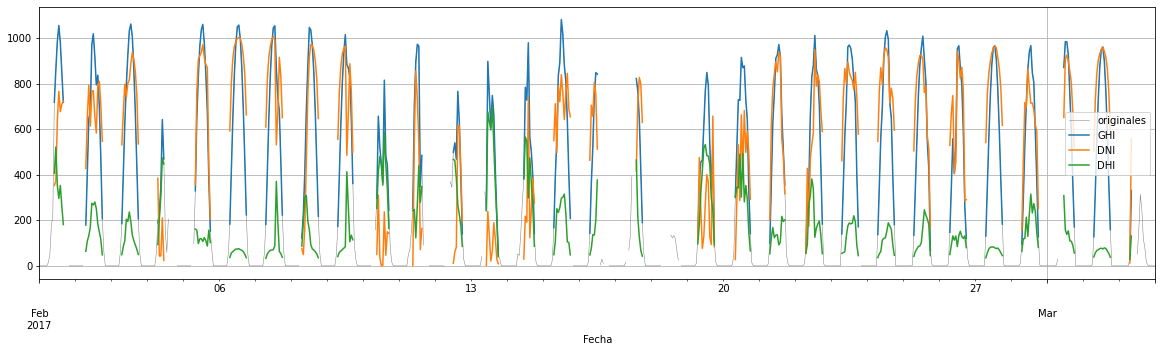

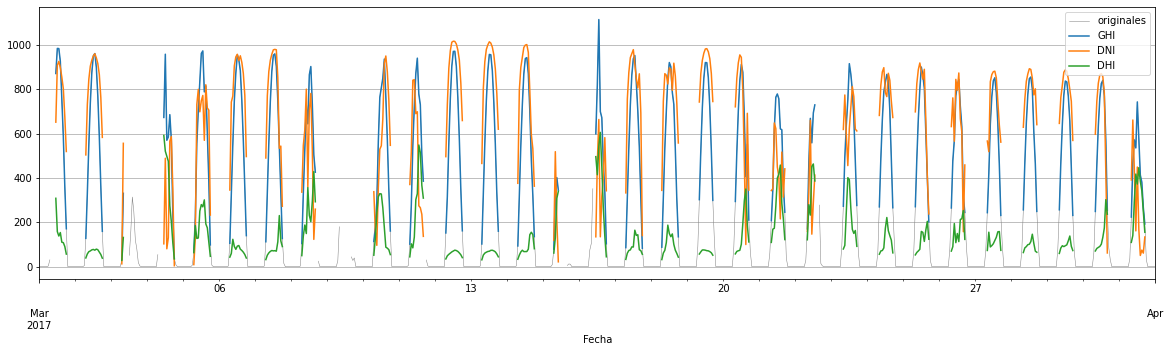

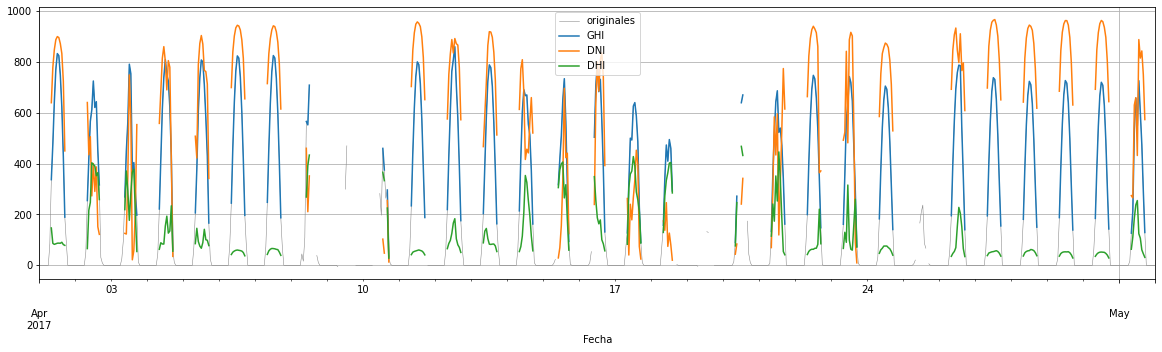

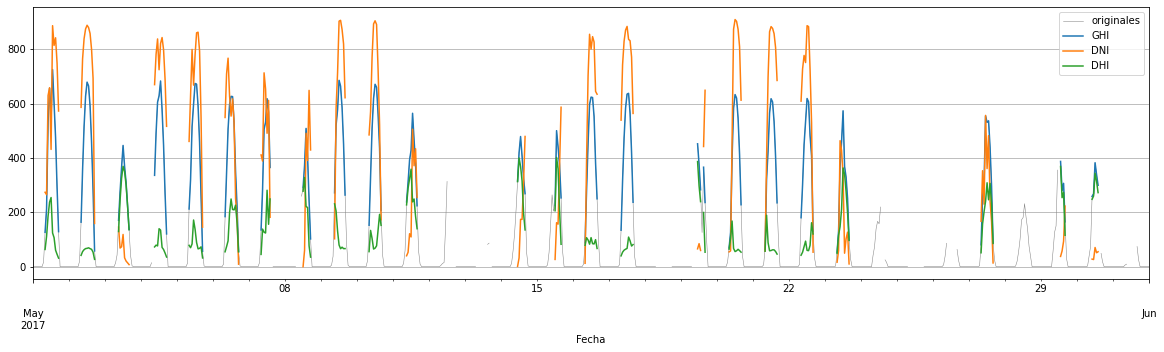

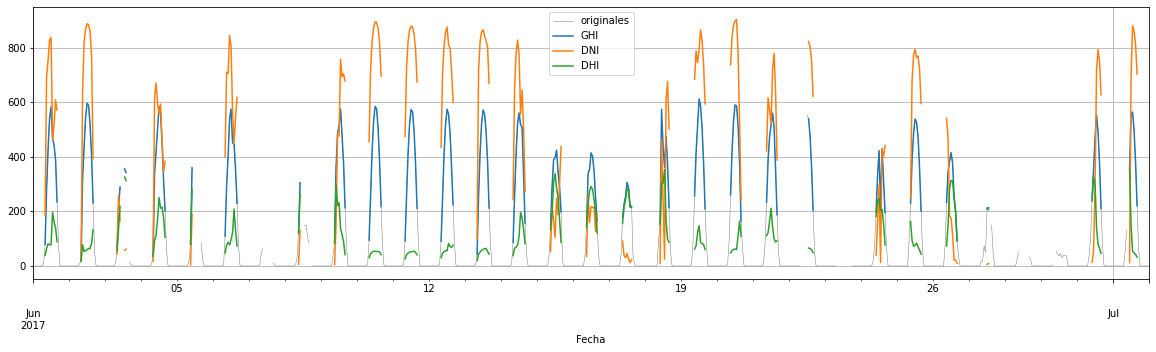

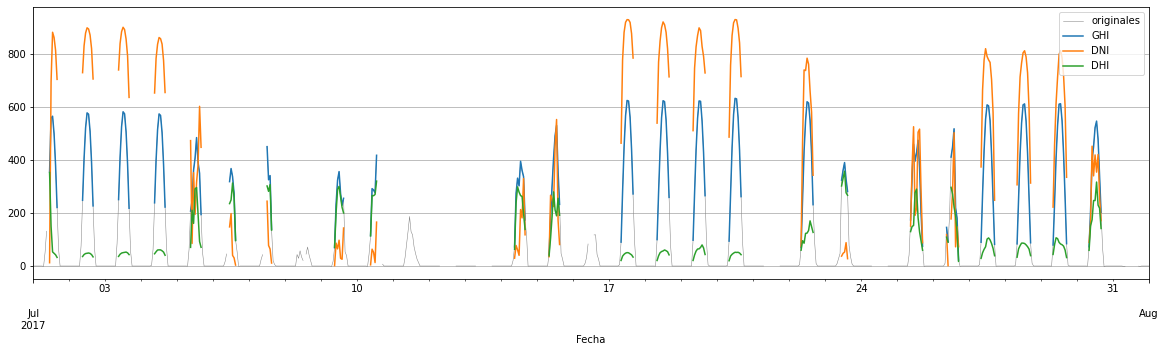

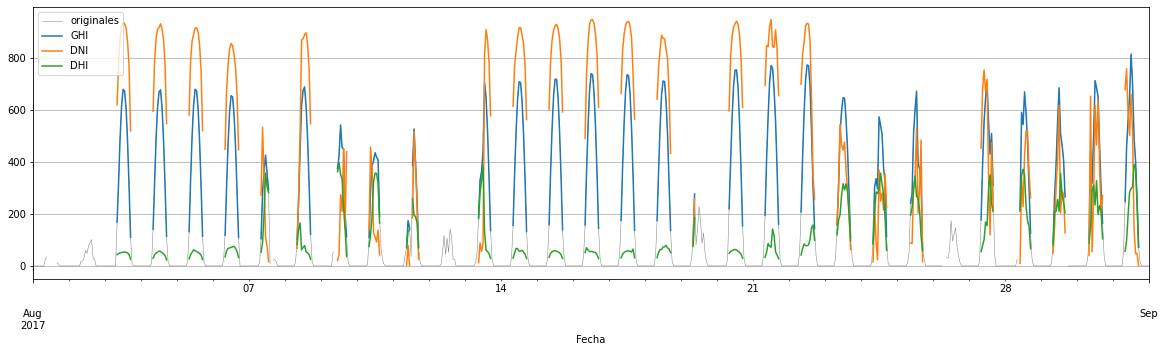

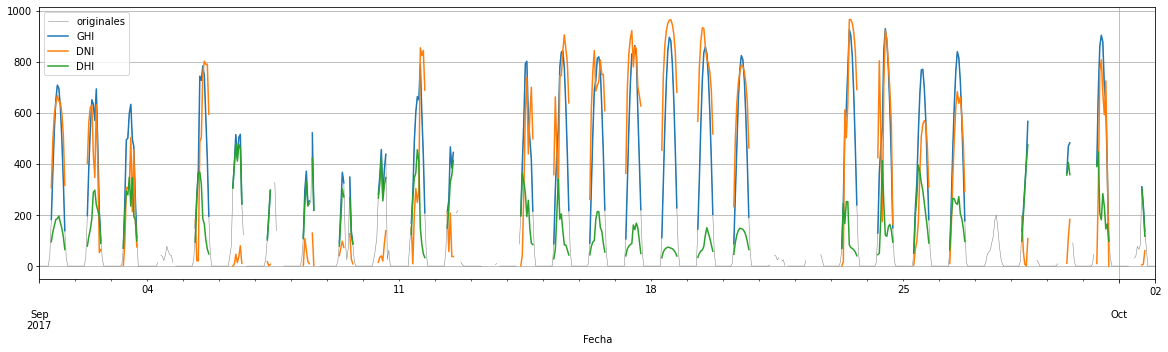

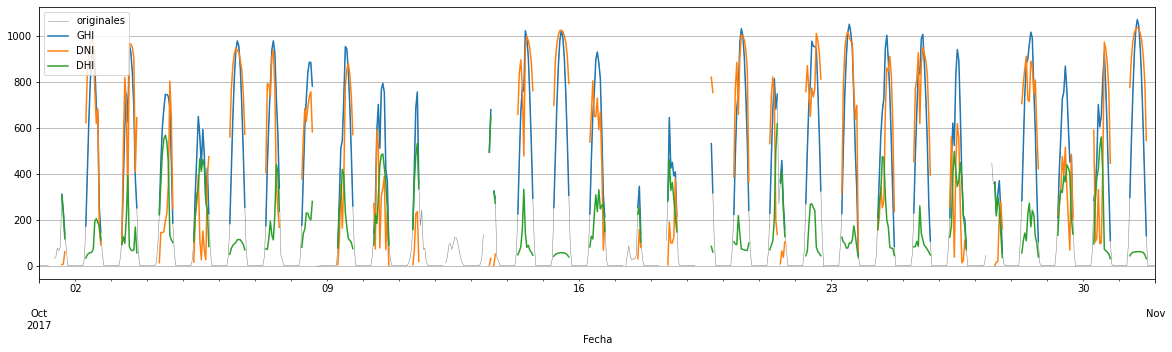

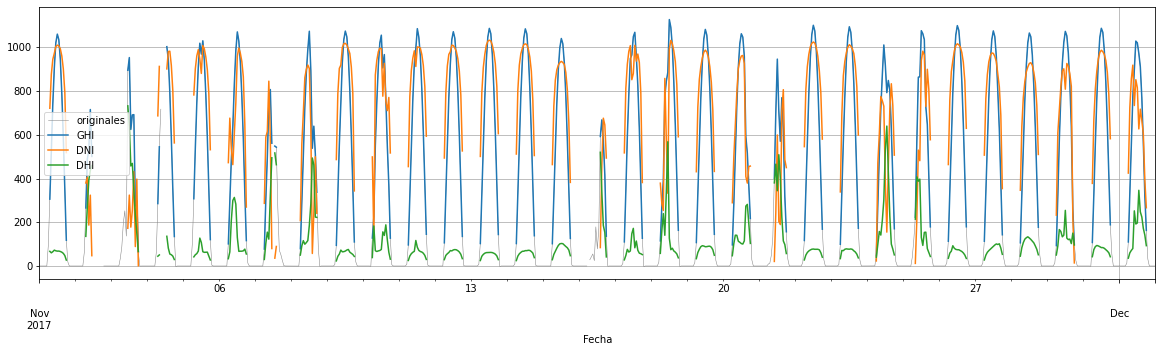

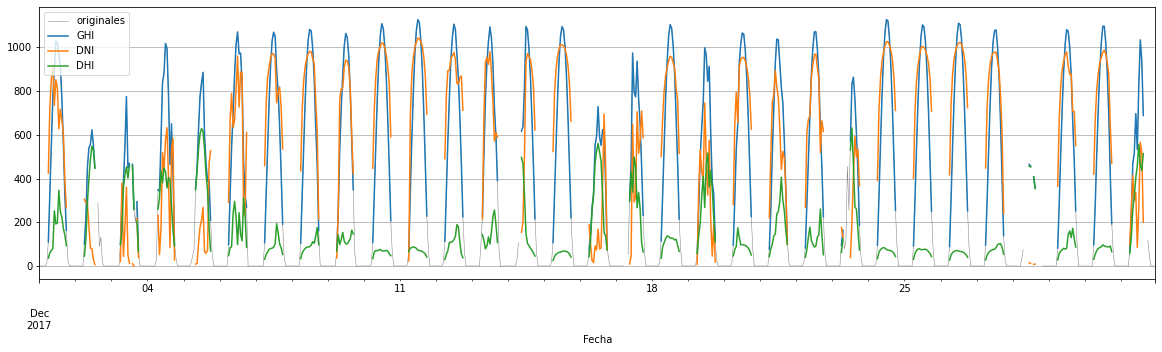

In [64]:
plt.rcParams['figure.figsize'] = (20, 5)
for mes in range(1, 13):
  start = datetime.datetime(2017, mes, 1)
  ax = saerroneosnan['originales'][start:start + datetime.timedelta(days=31)].plot(color='gray', lw=0.5)
  saerroneosnan[['GHI','DNI','DHI']][start:start + datetime.timedelta(days=31)].plot(ax=ax)
  plt.legend()
  plt.show()
plt.rcParams['figure.figsize'] = figsize

En principio lo que se observa son muchos faltantes de datos en las series.

La comparación del período original de GHI con los datos restantes muestra que el filtrado extrajo partes de días donde había problemas, pero que quedan valores de ese mismo día que no parecen del todo correctos.

En muchos lugares (generalmente en días que no pasaron el filtro) se observa que la GHI coincide con la DHI pero que además hay componente de DNI, por lo que se espera que la clausura no vaya a cerrar porque son inconsistentes.

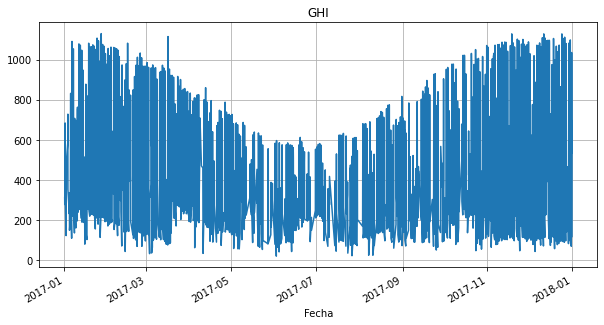

In [65]:
sacorrectos['GHI'].plot()
plt.title('GHI')
plt.show()

Mirando la estacionalidad, salta en eviencia un valor de sobreirradiancia el 13/03 que pasaba desapercibido en las series temporales y que no parece consistente siendo que se están manejando datos horarios y no deberían observarse este tipo de fenómenos.

Llama la atención la irregularidad en el valor mínimo que no parece corresponderse con el filtrado por CZ, por lo que se presupone que en el amanecer y ocaso ganaron los filtros de GHI, DNI y DHI > 0, o el de la fracción difusa, los cuales evidenciarían mala calidad en los datos.

---

Al trabajar con datos horarios no se observan fenómenos de sombras que se repitan en la serie.

---

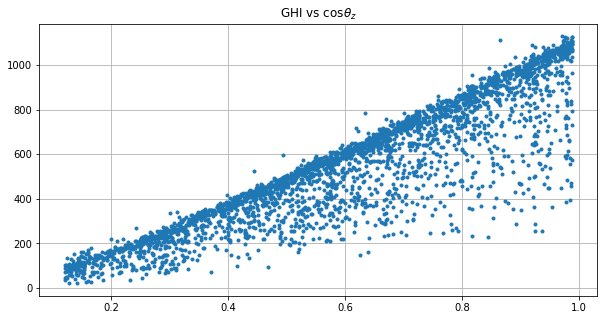

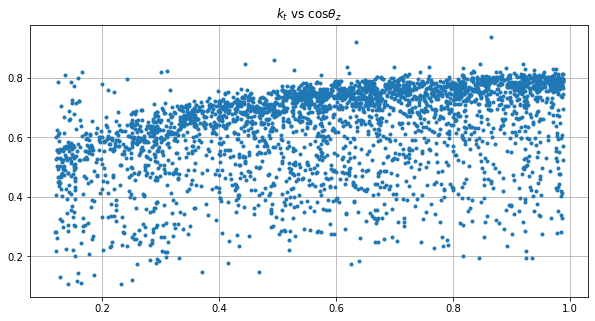

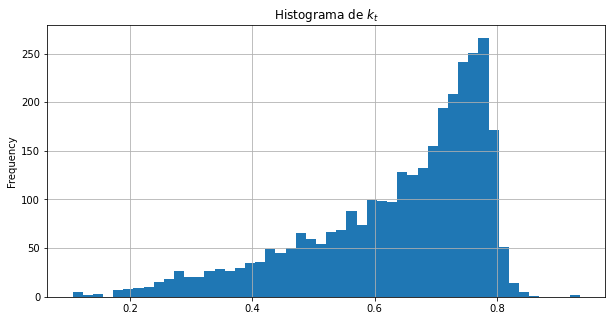

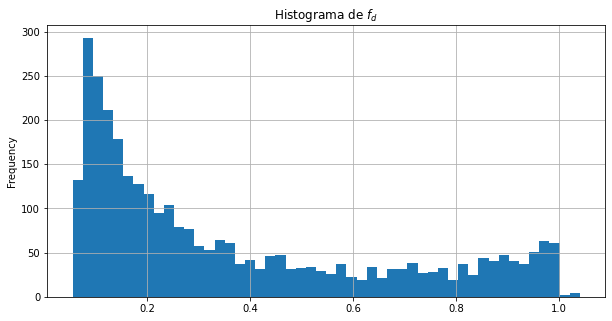

In [66]:
plt.plot(sacorrectos['CZ'], sacorrectos['GHI'], '.')
plt.title(r'GHI vs $\cos\theta_z$')
plt.show()

plt.plot(sacorrectos['CZ'], sacorrectos['kt'], '.')
plt.title(r'$k_t$ vs $\cos\theta_z$')
plt.show()

sacorrectos['kt'].plot.hist(bins=50)
plt.title('Histograma de $k_t$')
plt.show()

sacorrectos['fd'].plot.hist(bins=50)
plt.title('Histograma de $f_d$')
plt.show()

Los gráficos de $\cos\theta_z$ versus GHI y $k_t$ son consistentes con una serie sana.

Los gráficos de histograma de $k_t$ y $f_d$ son consistentes con los filtros aplicados. Básicamente, al haber eliminado los instantes de $\alpha_s$ < 7º se eliminan todos los momentos de claridad difusa del amanecer y el atardecer, por lo que los valores altos de $f_d$ están únicamente asociados a días completamente nublados.

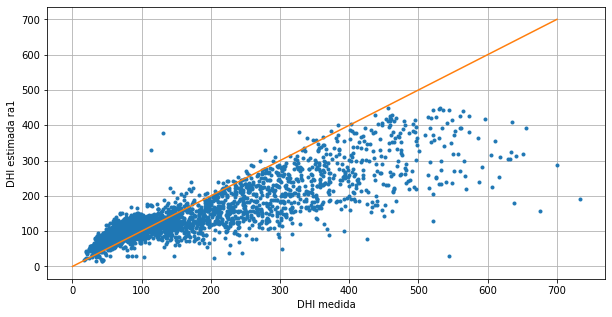

MBD%: 12.532925
RMSD%: 48.867031


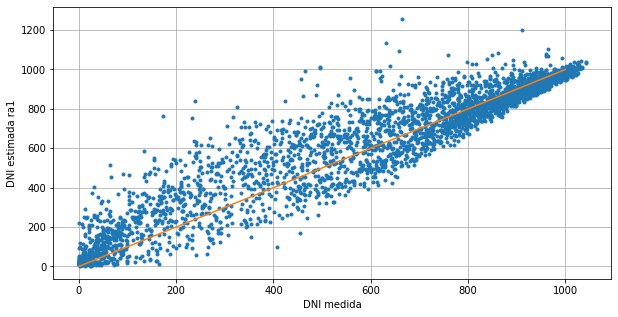

MBD%: -5.424936
RMSD%: 19.524657


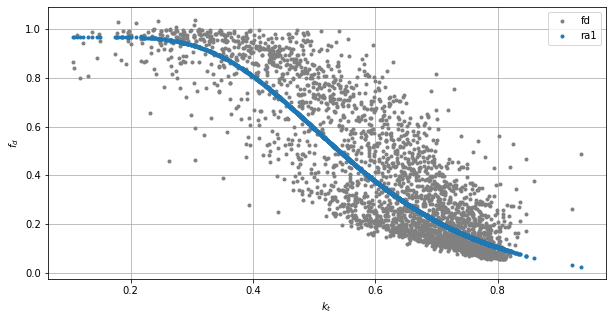

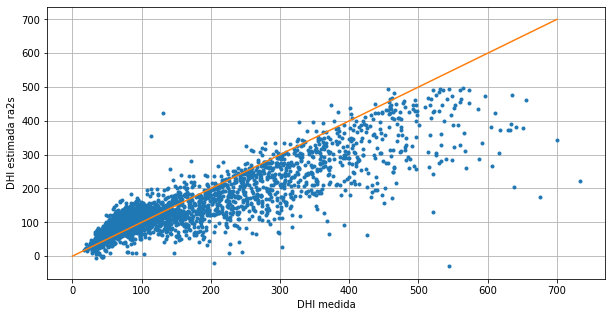

MBD%: 9.613265
RMSD%: 42.625039


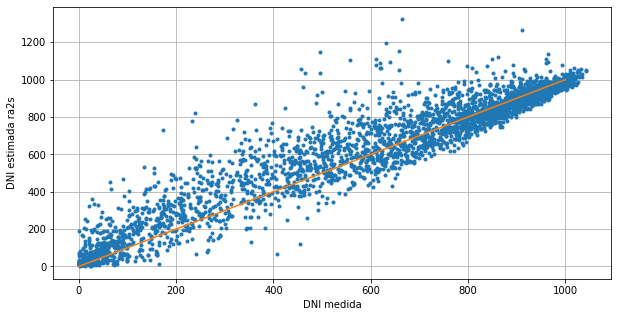

MBD%: -5.777698
RMSD%: 18.181114


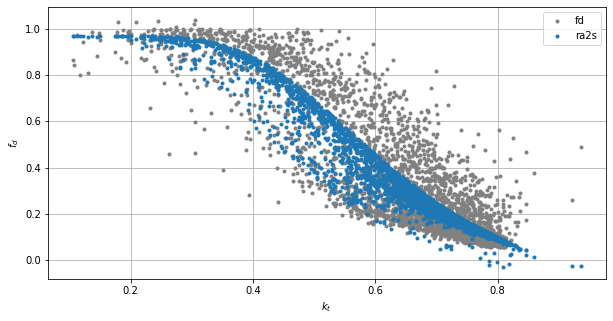

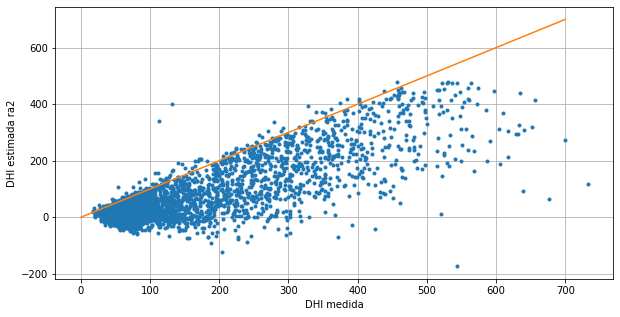

MBD%: 53.264035
RMSD%: 71.682960


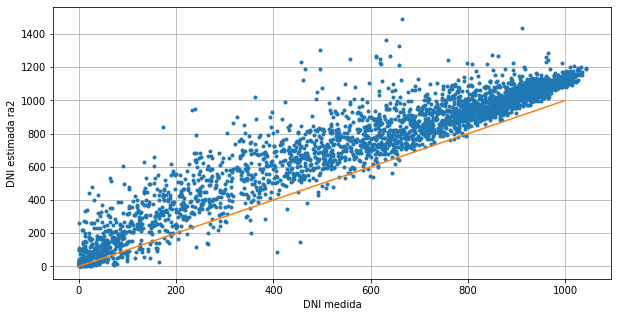

MBD%: -25.561443
RMSD%: 31.411185


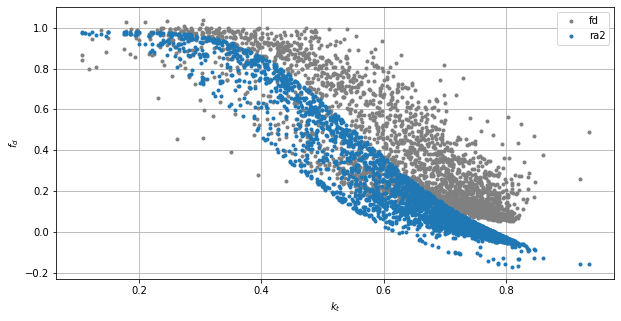

In [67]:
def ra1(kt):
  return 0.97 - 1.01 * exp(-exp(3.07 - 6.17 * kt))

def ra2s(kt, m):
  return 0.97 - 1.11 * exp(-exp(3.38 - 5.84 * kt - 0.13 * m))

def ra2(kt, m):
  return 0.98 - 1.24 * exp(-exp(3.47 - 5.71 * kt - 0.32 * m - 0.25 * kt * kt + 0.02 * m * m))

sacorrectos = sacorrectos.copy() # Lo desvinculamos de original

sacorrectos['m'] = sacorrectos['CZ'].apply(masa_de_aire)

sacorrectos['ra1'] = sacorrectos['kt'].apply(ra1)
sacorrectos['ra2s'] = sacorrectos.apply(lambda x: ra2s(x['kt'], x['m']), axis=1)
sacorrectos['ra2'] = sacorrectos.apply(lambda x: ra2(x['kt'], x['m']), axis=1)

for ra in ('ra1', 'ra2s', 'ra2'):
  sacorrectos['dhi estimada'] = sacorrectos.apply(lambda x: x['GHI'] * x[ra], axis=1)
  sacorrectos['dni estimada'] = sacorrectos.apply(lambda x: (x['GHI'] - x['dhi estimada']) / x['CZ'], axis=1)

  plt.plot(sacorrectos['DHI'], sacorrectos['dhi estimada'], '.')
  plt.plot([0, 700], [0, 700])
  plt.xlabel('DHI medida')
  plt.ylabel('DHI estimada %s' % ra)
  plt.show()

  err = (sacorrectos['DHI'] - sacorrectos['dhi estimada']) / sacorrectos['DHI'].mean()
  print('MBD%%: %f' % (sum(err) / len(err) * 100))
  print('RMSD%%: %f' % ((sum(err.apply(lambda x: x ** 2)) / len(err)) ** .5 * 100))

  plt.plot(sacorrectos['DNI'], sacorrectos['dni estimada'], '.')
  plt.plot([0, 1000], [0, 1000])
  plt.xlabel('DNI medida')
  plt.ylabel('DNI estimada %s' % ra)
  plt.show()

  err = (sacorrectos['DNI'] - sacorrectos['dni estimada']) / sacorrectos['DNI'].mean()
  print('MBD%%: %f' % (sum(err) / len(err) * 100))
  print('RMSD%%: %f' % ((sum(err.apply(lambda x: x ** 2)) / len(err)) ** .5 * 100))

  plt.plot(sacorrectos['kt'], sacorrectos['fd'], '.', label='fd', color='gray')
  plt.plot(sacorrectos['kt'], sacorrectos[ra], '.', label=ra)
  plt.xlabel('$k_t$')
  plt.ylabel('$f_d$')
  plt.legend()
  plt.show()

Se observa que la estimación RA2s es la que da más cercana a los valores medidos.

Para evaluar el desempeño por regiones utilizamos RA2s y DNI:

Región I: kt < 0.3
MBD%: 21.513372
RMSD%: 126.121397
Región II: 0.3 <= kt < 0.65
MBD%: -13.321051
RMSD%: 35.818763
Región III: kt >= 0.65
MBD%: -3.899505
RMSD%: 13.282177


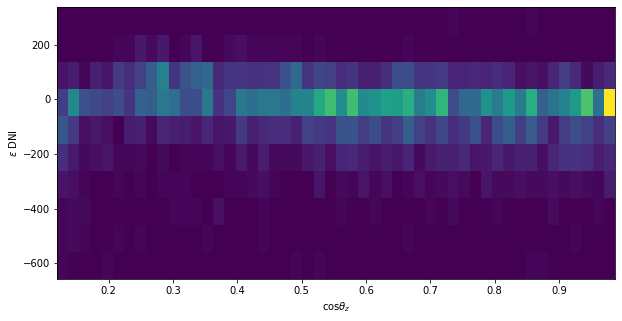

In [68]:
sacorrectos['dhi estimada'] = sacorrectos.apply(lambda x: x['GHI'] * x['ra2s'], axis=1)
sacorrectos['dni estimada'] = sacorrectos.apply(lambda x: (x['GHI'] - x['dhi estimada']) / x['CZ'], axis=1)

filtro = sacorrectos[sacorrectos['kt'] < 0.3]
err = (filtro['DNI'] - filtro['dni estimada']) / filtro['DNI'].mean()
print('Región I: kt < 0.3')
print('MBD%%: %f' % (sum(err) / len(err) * 100))
print('RMSD%%: %f' % ((sum(err.apply(lambda x: x ** 2)) / len(err)) ** .5 * 100))

                  # No puedo creer que a < x < b no anda en los filtros de Pandas
filtro = sacorrectos[(sacorrectos['kt'] >= 0.3) & (sacorrectos['kt'] < 0.65)]
err = (filtro['DNI'] - filtro['dni estimada']) / filtro['DNI'].mean()
print('Región II: 0.3 <= kt < 0.65')
print('MBD%%: %f' % (sum(err) / len(err) * 100))
print('RMSD%%: %f' % ((sum(err.apply(lambda x: x ** 2)) / len(err)) ** .5 * 100))

filtro = sacorrectos[sacorrectos['kt'] >= 0.65]
err = (filtro['DNI'] - filtro['dni estimada']) / filtro['DNI'].mean()
print('Región III: kt >= 0.65')
print('MBD%%: %f' % (sum(err) / len(err) * 100))
print('RMSD%%: %f' % ((sum(err.apply(lambda x: x ** 2)) / len(err)) ** .5 * 100))

err = sacorrectos['DNI'] - sacorrectos['dni estimada']
#plt.plot(sacorrectos['CZ'], err, '.')
plt.hist2d(sacorrectos['CZ'], err, bins=[50, 10])
plt.xlabel(r'$\cos\theta_z$')
plt.ylabel(r'$\varepsilon$ DNI')
plt.show()

Se observa un error menor en la región III, asociada a $k_t \geq 0.65$.

En cuanto al desempeño en función de la altura se propone graficar el histograma del error en función de $\cos\theta_z$. Parece ser que a valores mayores de la altura solar hay más concentración de valores con bajo error; pero tampoco se observa una tendencia muy marcada en este sentido.

Ejercicio 6
-----------

Se eligen los 5 días a partir del 13/06, donde el 13 es un día de cielo claro y el tiempo va empeorando siendo el último día totalmente nublado.

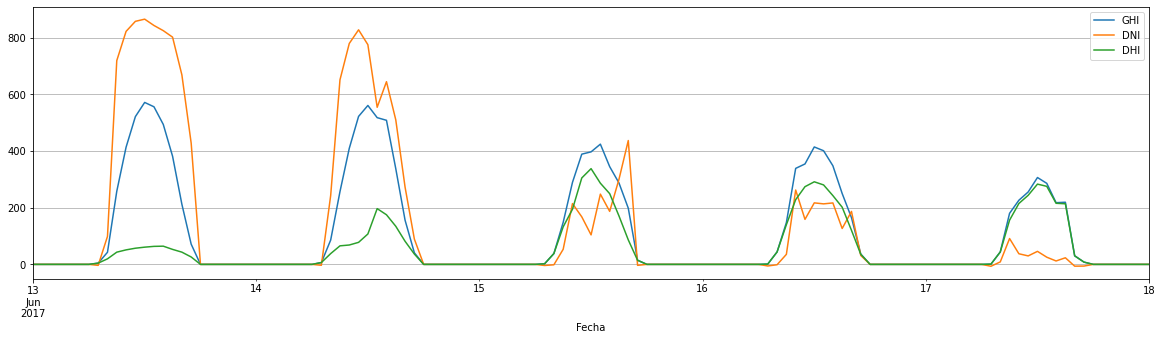

In [69]:
sa5 = sa[datetime.datetime(2017, 6, 13):datetime.datetime(2017, 6, 18)].copy()

plt.rcParams['figure.figsize'] = (20, 5)
sa5[['GHI','DNI','DHI']].plot()
plt.rcParams['figure.figsize'] = figsize

In [70]:
beta = radians(30)
rog = 0.55
salateq = salat + beta

def computar_costheta(row):
  n = row['N']
  nr = row['NR']
  omega = inversa_tiempo_estandar(n, nr, salon, huso)
  
  return cos(angulo_cenital(n, omega, salateq)) # El theta se calcula con la longitud equivalente

def computar_rb(row):
  cz = row['CZ']
  ct = row['ct']

  if cz <= 0 or ct <= 0: return 0
  return ct / cz

sa5['ct'] = sa5.apply(computar_costheta, axis=1)
sa5['rb'] = sa5.apply(computar_rb, axis=1)

sa5['bhi'] = sa5.apply(lambda x: x['DNI'] * x['CZ'], axis=1)
sa5['gbi'] = sa5.apply(lambda x: x['bhi'] * x['rb'], axis=1)

fc_sky = 0.5 * (1 + cos(beta))
fc_g = 1 - fc_sky

sa5['gri'] = sa5['GHI'].apply(lambda x: rog * x * fc_g)

def calcular_gdi_hdkr(row):
  n = row['N']
  gb = row['DNI']
  gdh = row['DHI']
  gh = row['GHI']
  rb = row['rb']

  fd = gdh / gh if gh > 0 else 1
  ai = gb / irradiancia_TOA(n)

  f = (1 - fd) ** .5

  return (1 - ai) * gdh * fc_sky * (1 + f * sin(beta/2) ** 3) + ai * gdh * rb

sa5['gdi'] = sa5.apply(calcular_gdi_hdkr, axis=1)

sa5['gti'] = sa5.apply(lambda x: x['gbi'] + x['gdi'] + x['gri'], axis=1)

Resultados:

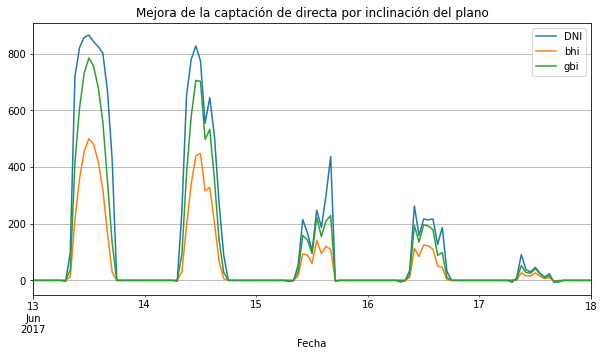

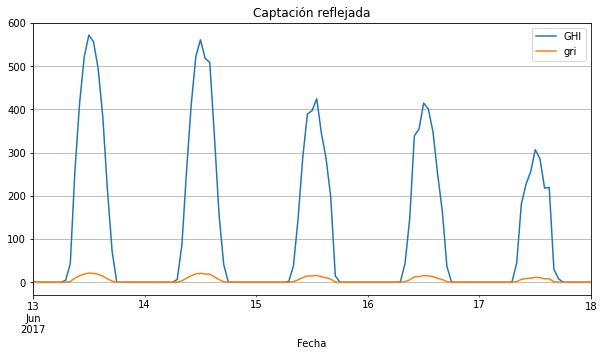

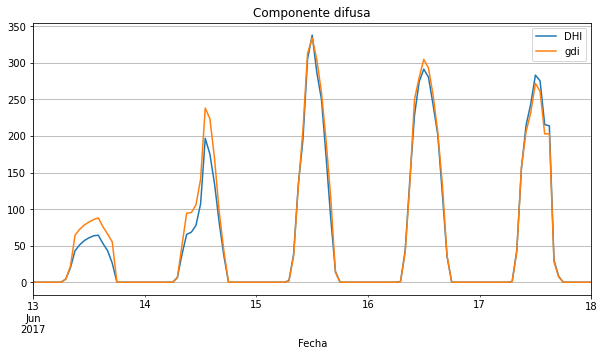

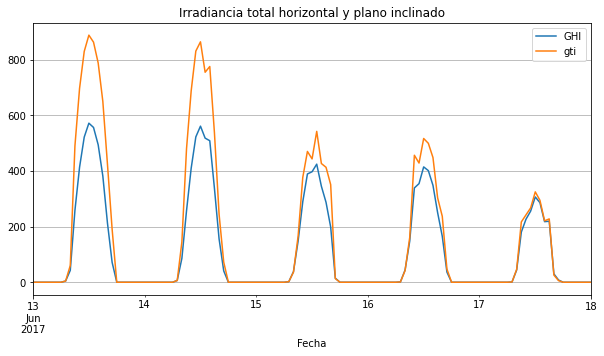

In [71]:
sa5[['DNI', 'bhi', 'gbi']].plot()
plt.title('Mejora de la captación de directa por inclinación del plano')
plt.show()

sa5[['GHI', 'gri']].plot()
plt.title('Captación reflejada')
plt.show()

sa5[['DHI', 'gdi']].plot()
plt.title('Componente difusa')
plt.show()

sa5[['GHI', 'gti']].plot()
plt.title('Irradiancia total horizontal y plano inclinado')
plt.show()

Se observa que el pasaje a plano inclinado eleva mucho la captación de directa, básicamente el ángulo es prácticamente igual a la latitud del sitio.

La componente de reflejada no aporta cantidades significativas.

La componente de difusa está asociada al factor $f$ que incrementa la contribución en días de cielo despejado.

Finalmente, comparando la irradiancia total se observa una mejora significativa en los días en los cuales hay cielo claro, pero la misma cantidad en el caso del día completamente nublado.

Ejercicio 7
-----------

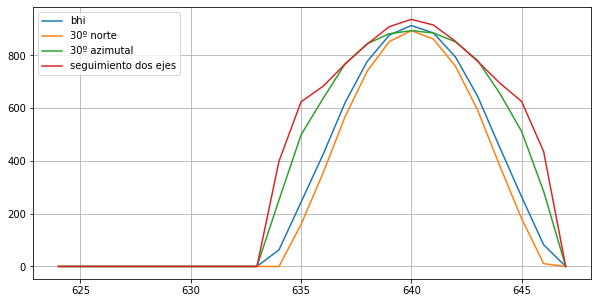

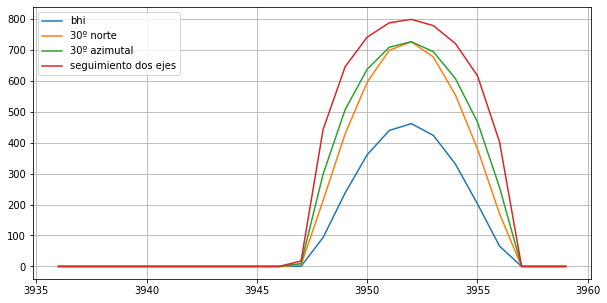

Ganancia inclinado versus horizontal 11.4%
Ganancia 1 eje 25.6%
Ganancia 2 ejes 39.6%


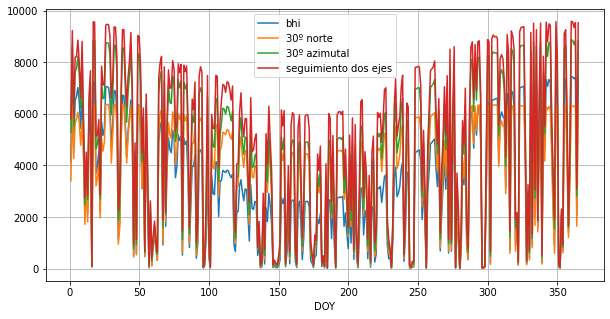

In [72]:
saamt = pandas.read_csv('AMTUes_v2-4_SAL_horario.csv')


def computar_directa(row, ejes=0):
  n = row['DOY']
  nr = row['HS']
  cz = row['CZ']
  dni = row['DNI']

  delta = declinacion_solar_spencer(n)
  omega = inversa_tiempo_estandar(n, nr, salon, 0)  # Están en hora local

  gamma = omega if ejes > 0 else 0
  beta = radians(30) if ejes < 2 else acos(cz)

  ct = (sin(delta) * sin(salat) + cos(delta) * cos(salat) * cos(omega)) * cos(beta) + \
    ((sin(delta) * cos(salat) - cos(delta) * sin(salat) * cos(omega)) * cos(gamma) + \
    cos(delta) * sin(omega) * sin(gamma)) * sin(beta)
  
  if cz <= 0 or ct <= 0: return 0

  return ct * dni

saamt['bhi'] = saamt['DNI'] * saamt['CZ']
saamt['30º norte'] = saamt.apply(lambda x: computar_directa(x, 0), axis=1)
saamt['30º azimutal'] = saamt.apply(lambda x: computar_directa(x, 1), axis=1)
saamt['seguimiento dos ejes'] = saamt.apply(lambda x: computar_directa(x, 2), axis=1)


#saamt[['DNI', '30º norte', '30º azimutal', 'seguimiento dos ejes']][:100].plot()

saamt[saamt['DOY'] == 27 ][['bhi', '30º norte', '30º azimutal', 'seguimiento dos ejes']].plot()
plt.show()

saamt[saamt['DOY'] == 165 ][['bhi', '30º norte', '30º azimutal', 'seguimiento dos ejes']].plot()
plt.show()

saamt.groupby('DOY').sum()[['bhi', '30º norte', '30º azimutal', 'seguimiento dos ejes']].plot()

saamtsum = saamt.sum()
print('Ganancia inclinado versus horizontal %.1f%%' % (saamtsum['30º norte'] / saamtsum['bhi'] * 100 - 100))
print('Ganancia 1 eje %.1f%%' % (saamtsum['30º azimutal'] / saamtsum['30º norte'] * 100 - 100))
print('Ganancia 2 ejes %.1f%%' % (saamtsum['seguimiento dos ejes'] / saamtsum['30º norte'] * 100 - 100))

Se observa una ganancia del 26% por agregar un eje y del 40% por agregar dos.

En el caso de panel fijo se observa que en días de verano la captación es menor a la que se obtendría sobre un plano horizontal.

En el caso del seguimiento con un eje, con excepción del cénit en el verano (momento en el que el panel mira al norte), se aprovecha mejor el recurso durante todo el día.

En el caso del seguimiento con dos ejes, los valores simulados se parecen a los de DNI, por lo que el aprovechamiento es máximo.

Ejercicio 8
-----------

En realidad en el ejercicio 4 no estaban calculados DHI y DNI, los calculamos con RA2S.

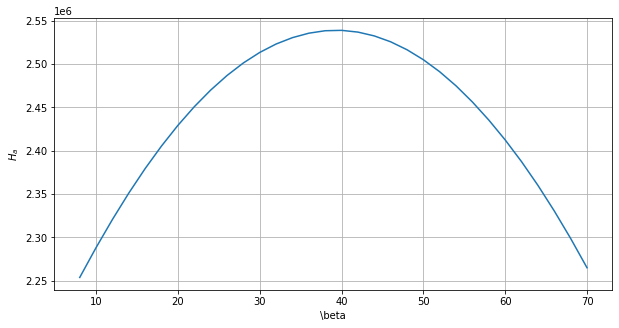

2538833.035111456


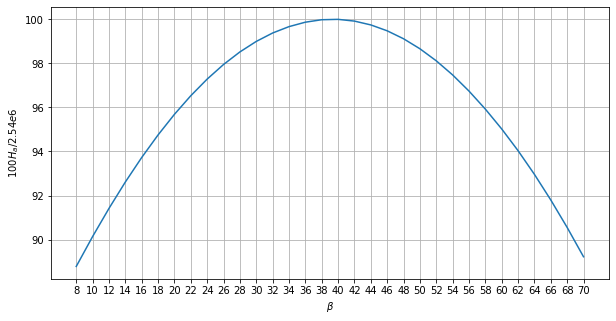

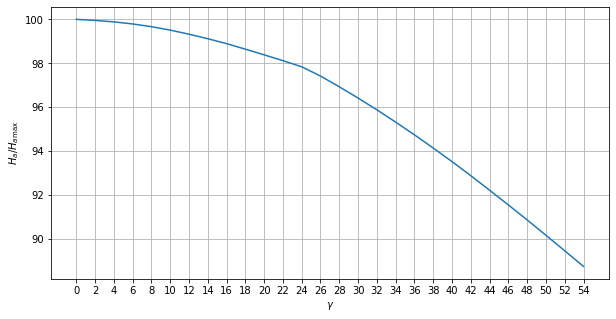

In [82]:
rog = 0.4

lbest = lb[['N', 'NR', 'CZ']].copy()
lbest['GHI'] = lb['ghicc']
lbest['kt'] = lbest['GHI'] / lb['goh']

lbest['m'] = lbest['CZ'].apply(masa_de_aire)
lbest['ra2s'] = lbest.apply(lambda x: ra2s(x['kt'], x['m']), axis=1)

lbest['DHI'] = lbest.apply(lambda x: x['GHI'] * x['ra2s'], axis=1)
lbest['DNI'] = lbest.apply(lambda x: (x['GHI'] - x['DHI']) / x['CZ'], axis=1)


def computar_total(row, beta, gamma=0):
  n = row['N']
  nr = row['NR']
  cz = row['CZ']
  ghi = row['GHI']
  dni = row['DNI']
  dhi = row['DHI']

  delta = declinacion_solar_spencer(n)
  omega = inversa_tiempo_estandar(n, nr - 0.5, lblon, huso)

  ct = (sin(delta) * sin(lblat) + cos(delta) * cos(lblat) * cos(omega)) * cos(beta) + \
    ((sin(delta) * cos(lblat) - cos(delta) * sin(lblat) * cos(omega)) * cos(gamma) + \
    cos(delta) * sin(omega) * sin(gamma)) * sin(beta)
  
  rb = ct / cz
  if cz <= 0 or ct <= 0:
    rb = 0

  bhi = dni * cz
  gbi = bhi * rb

  fc_sky = 0.5 * (1 + cos(beta))
  fc_g = 1 - fc_sky

  gri = ghi * rog * fc_g

  gb = dni
  gdh = dhi
  gh = ghi

  fd = gdh / gh if gh > 0 else 1
  ai = gb / irradiancia_TOA(n)

  f = (1 - fd) ** .5

  gdi_hdkr = (1 - ai) * gdh * fc_sky * (1 + f * sin(beta/2) ** 3) + ai * gdh * rb

  return gbi + gdi_hdkr + gri

paso = 10

betas = list(range(8, 72, paso))
has = []
for beta in betas:
  has.append(lbest.apply(lambda x: computar_total(x, radians(beta)), axis=1).sum())

plt.plot(betas, has)
plt.ylabel('$H_a$')
plt.xlabel(r'\beta')
plt.show()

print(max(has))
hasperc = [x / max(has) * 100 for x in has]

fig,axes=plt.subplots(1,1)
plt.plot(betas, hasperc)
axes.xaxis.set_ticks(betas)
plt.ylabel('$100 H_a / 2.54e6$')
plt.xlabel(r'$\beta$')
plt.show()

gammas = list(range(0, 56, paso))
has = []
for gamma in gammas:
  has.append(lbest.apply(lambda x: computar_total(x, radians(30), radians(gamma)), axis=1).sum())

hasperc = [x / max(has) * 100 for x in has]

fig,axes=plt.subplots(1,1)
plt.plot(gammas, hasperc)
plt.ylabel(r'$H_a / H_{a\mathrm{ max}}$')
plt.xlabel(r'$\gamma$')
axes.xaxis.set_ticks(gammas)
plt.show()


Ejercicio 9
-----------

Registros originales: 525600
Registros existentes GHI, DNI, DHI: 515906
Registros diurnos: 257535
Filtro de GHI: 257481
Filtro de DHI: 213288
Filtro de DNI: 195107
Filtro de fracción difusa: 189198
Filtro de clausura: 183027


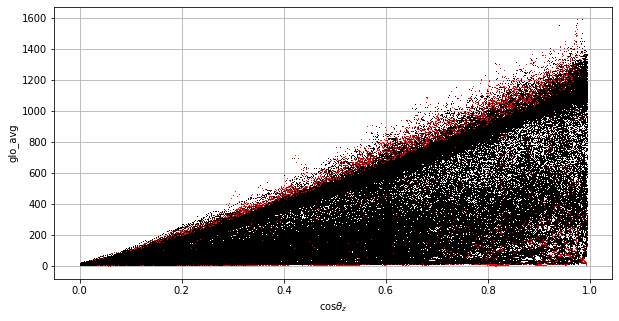

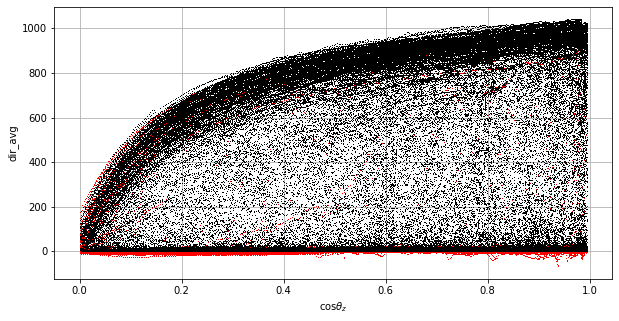

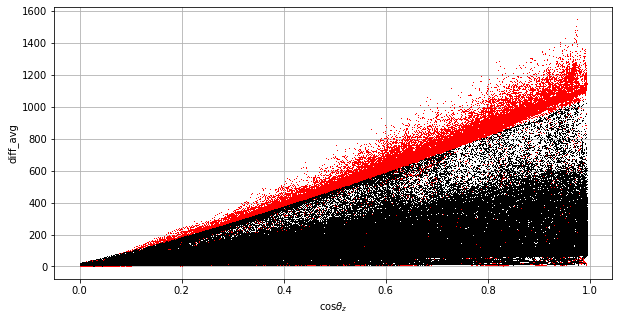

In [83]:
smlat = radians(-29.4428)  # Están en UTC-3
smlon = radians(-53.8231)

def computar_cz(row):
  n = row['day']
  nr = row['min'] / 60
                                 # A resolucion minutal no tiene sentido corregir con 1/2
  omega = inversa_tiempo_estandar(n, nr, smlon, 0)
  return cos(angulo_cenital(n, omega, smlat))

sm = pandas.read_csv('2013_SM.csv')

print('Registros originales:', len(sm))

sm = sm[(~pandas.isna(sm['glo_avg'])) & (~pandas.isna(sm['dir_avg'])) & (~pandas.isna(sm['diff_avg']))]

print('Registros existentes GHI, DNI, DHI:', len(sm))

sm['cz'] = sm.apply(computar_cz, axis=1)

sm = sm[sm['cz'] > 0]

print('Registros diurnos:', len(sm))

smnofiltrados = sm.copy()

sm = sm[(sm['glo_avg'] > -2) & (sm['glo_avg'] < GS * 1.2 * sm['cz'] ** 1.2 + 50)]
print('Filtro de GHI:', len(sm))

sm = sm[(sm['diff_avg'] > -2) & (sm['diff_avg'] < GS * 0.75 * sm['cz'] ** 1.2 + 30)]
print('Filtro de DHI:', len(sm))

sm = sm[(sm['dir_avg'] > -2) & (sm['dir_avg'] < GS * 0.95 * sm['cz'] ** 0.2 + 10)]
print('Filtro de DNI:', len(sm))

def calcular_fd(row):
  if row['glo_avg'] == 0:
    return 1
  return row['diff_avg'] / row['glo_avg']

sm['fd'] = sm.apply(calcular_fd, axis=1)

sm = sm[~((sm['fd'] > 1.05) & (sm['cz'] < radians(75)))]
sm = sm[~((sm['fd'] > 1.10) & (sm['cz'] > radians(75)))]
print('Filtro de fracción difusa:', len(sm))

def calcular_r(x):
  q = (x['diff_avg'] + x['dir_avg'] * x['cz'])
  if q == 0:
    return 1000
  return x['glo_avg'] / q

sm['r'] = sm.apply(calcular_r, axis=1)

sm = sm[~((sm['r'] > 1.08) & (sm['cz'] < radians(75)))]
sm = sm[~((sm['r'] < 0.92) & (sm['cz'] < radians(75)))]
sm = sm[~((sm['r'] > 1.15) & (sm['cz'] > radians(75)))]
sm = sm[~((sm['r'] < 0.85) & (sm['cz'] > radians(75)))]
print('Filtro de clausura:', len(sm))

for var in ('glo_avg', 'dir_avg', 'diff_avg'):
  plt.plot(smnofiltrados['cz'], smnofiltrados[var], ',', color='red')
  plt.plot(sm['cz'], sm[var], ',', color='black')
  plt.xlabel(r'$\cos\theta_z$')
  plt.ylabel(var)
  plt.show()

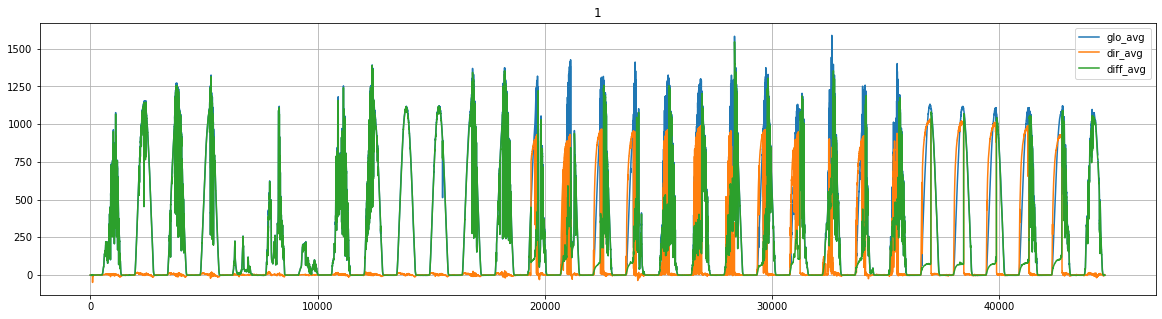

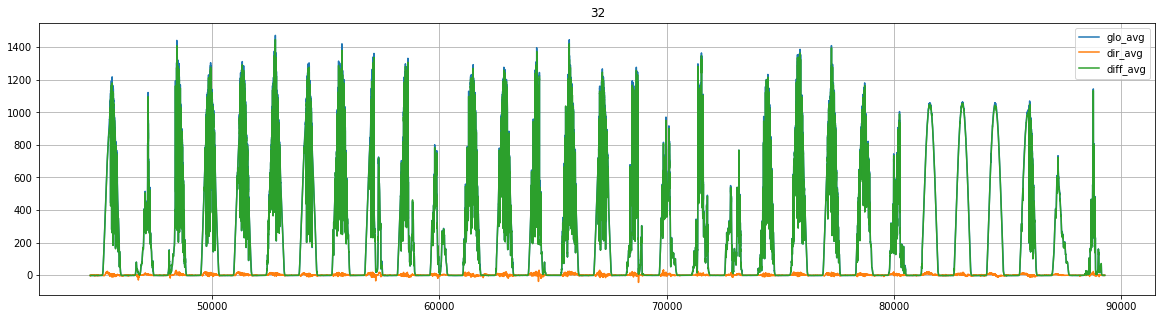

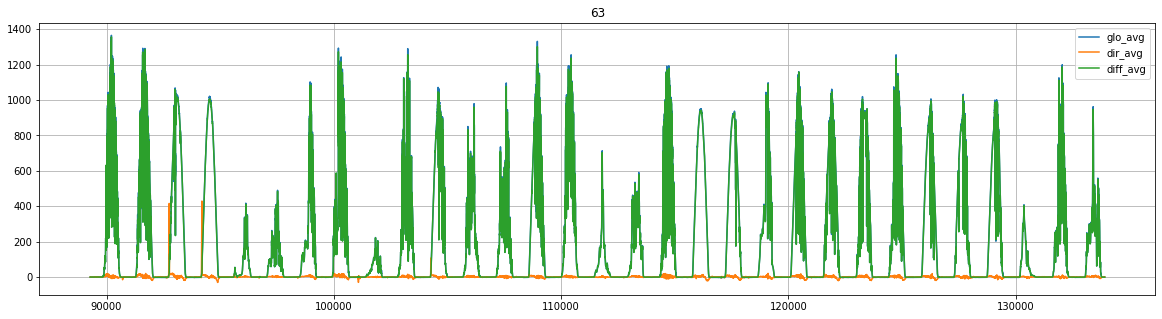

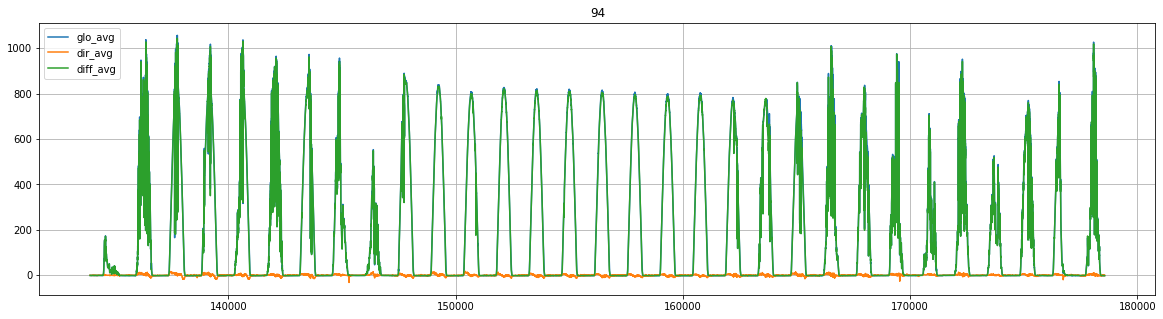

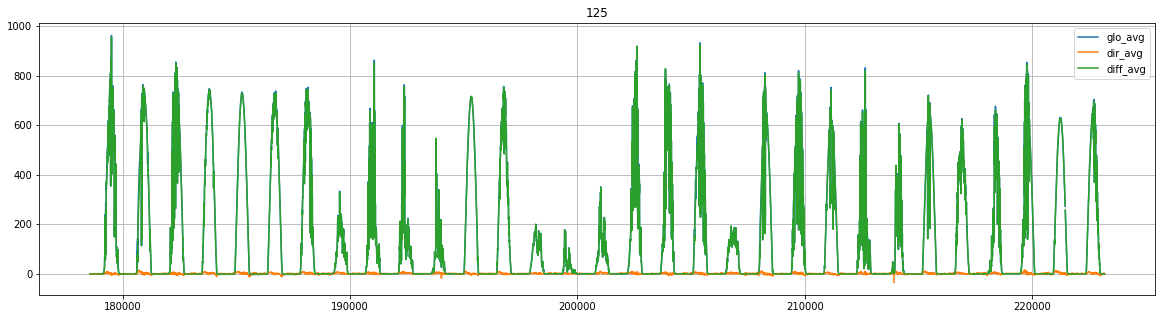

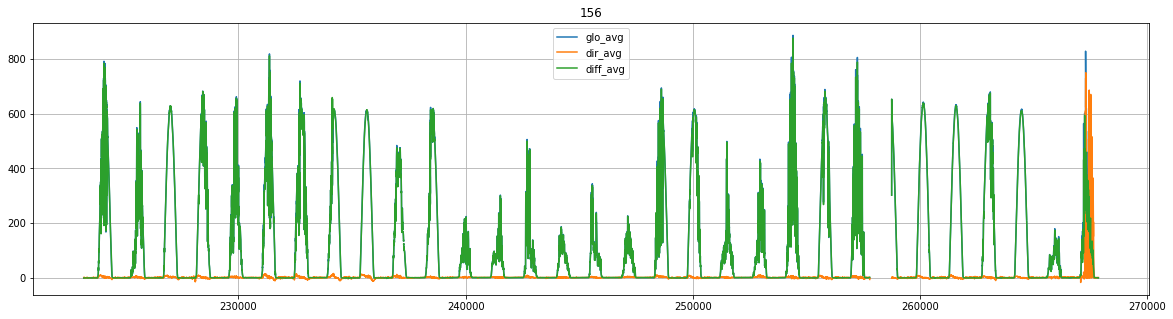

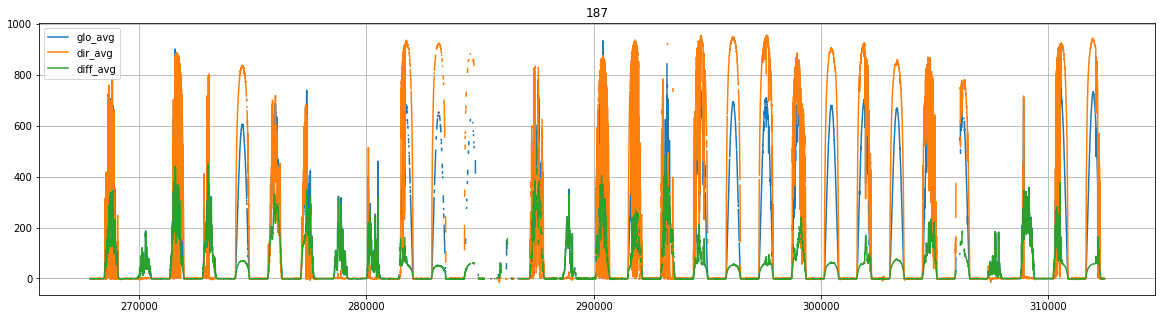

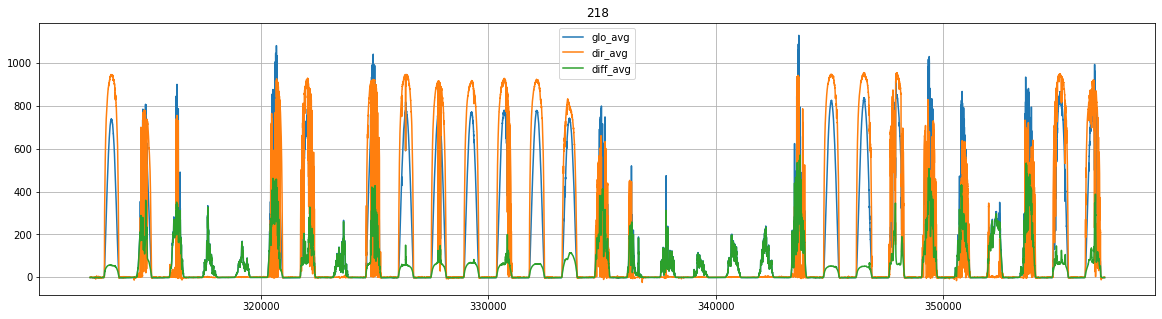

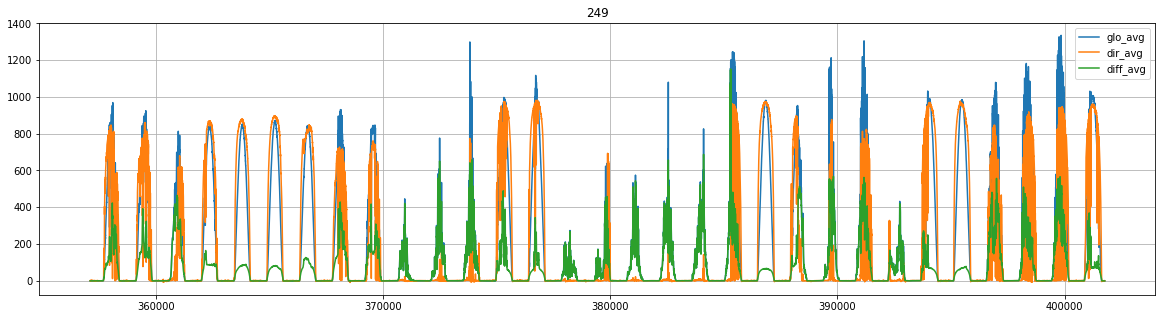

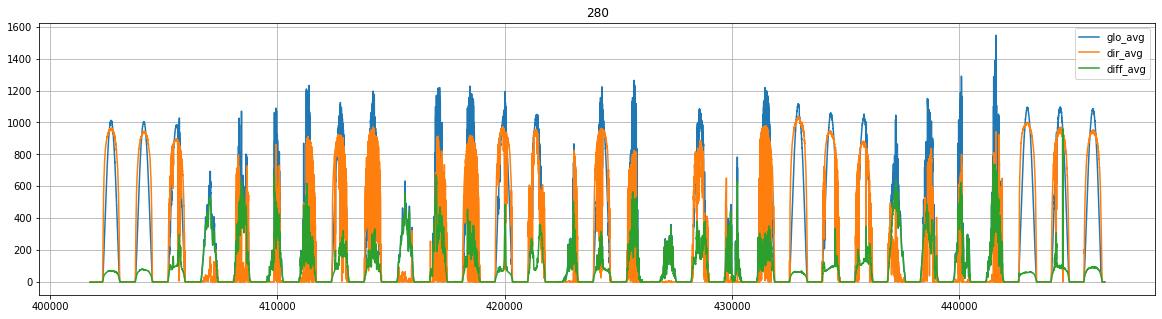

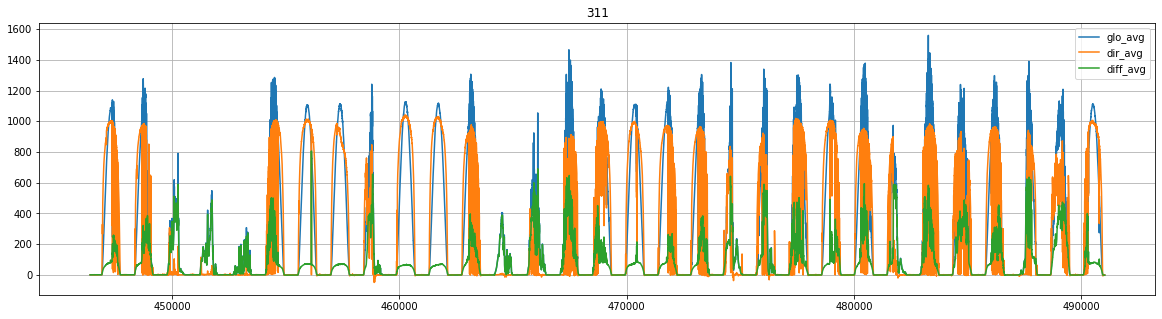

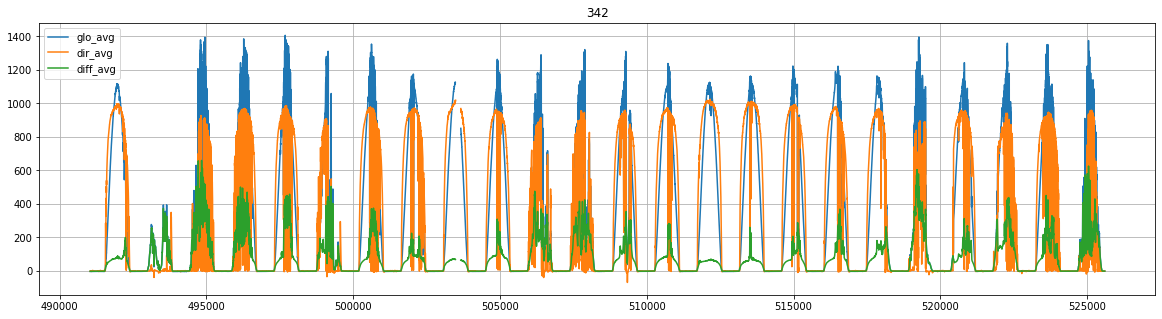

In [100]:
sm = pandas.read_csv('2013_SM.csv')

paso = 31
plt.rcParams['figure.figsize'] = (20, 5)
for day in range(1, 366, paso):
  sm[(sm['day'] >= day) & (sm['day'] < day + paso)][['glo_avg', 'dir_avg', 'diff_avg']].plot()
  plt.title(str(day))
  plt.show()
plt.rcParams['figure.figsize'] = figsize


Registros originales: 257760
Registros existentes GHI, DNI, DHI: 249133
Registros diurnos: 126938
Filtro de GHI: 126890
Filtro de DHI: 126849
Filtro de DNI: 123688
Filtro de fracción difusa: 121159
Filtro de clausura: 117444


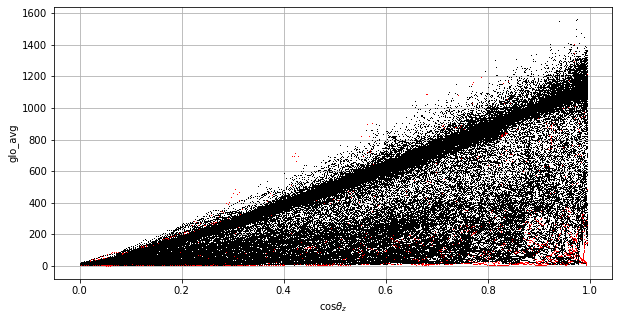

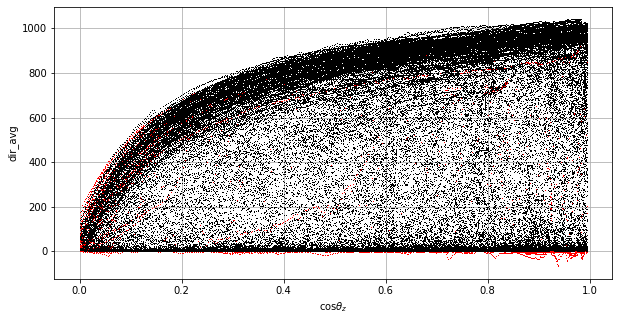

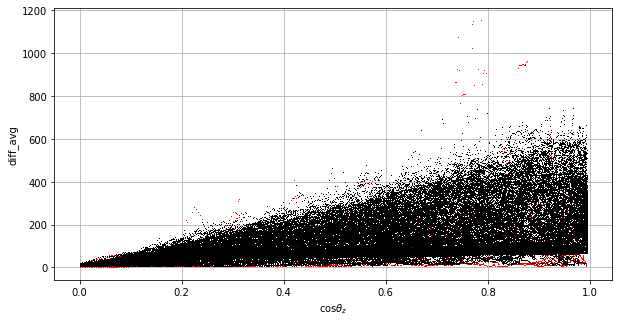

In [101]:
sm = sm[sm['day'] > 186]

print('Registros originales:', len(sm))

sm = sm[(~pandas.isna(sm['glo_avg'])) & (~pandas.isna(sm['dir_avg'])) & (~pandas.isna(sm['diff_avg']))]

print('Registros existentes GHI, DNI, DHI:', len(sm))

sm['cz'] = sm.apply(computar_cz, axis=1)

sm = sm[sm['cz'] > 0]

print('Registros diurnos:', len(sm))

smnofiltrados = sm.copy()

sm = sm[(sm['glo_avg'] > -2) & (sm['glo_avg'] < GS * 1.2 * sm['cz'] ** 1.2 + 50)]
print('Filtro de GHI:', len(sm))

sm = sm[(sm['diff_avg'] > -2) & (sm['diff_avg'] < GS * 0.75 * sm['cz'] ** 1.2 + 30)]
print('Filtro de DHI:', len(sm))

sm = sm[(sm['dir_avg'] > -2) & (sm['dir_avg'] < GS * 0.95 * sm['cz'] ** 0.2 + 10)]
print('Filtro de DNI:', len(sm))

def calcular_fd(row):
  if row['glo_avg'] == 0:
    return 1
  return row['diff_avg'] / row['glo_avg']

sm['fd'] = sm.apply(calcular_fd, axis=1)

sm = sm[~((sm['fd'] > 1.05) & (sm['cz'] < radians(75)))]
sm = sm[~((sm['fd'] > 1.10) & (sm['cz'] > radians(75)))]
print('Filtro de fracción difusa:', len(sm))

def calcular_r(x):
  q = (x['diff_avg'] + x['dir_avg'] * x['cz'])
  if q == 0:
    return 1000
  return x['glo_avg'] / q

sm['r'] = sm.apply(calcular_r, axis=1)

sm = sm[~((sm['r'] > 1.08) & (sm['cz'] < radians(75)))]
sm = sm[~((sm['r'] < 0.92) & (sm['cz'] < radians(75)))]
sm = sm[~((sm['r'] > 1.15) & (sm['cz'] > radians(75)))]
sm = sm[~((sm['r'] < 0.85) & (sm['cz'] > radians(75)))]
print('Filtro de clausura:', len(sm))

for var in ('glo_avg', 'dir_avg', 'diff_avg'):
  plt.plot(smnofiltrados['cz'], smnofiltrados[var], ',', color='red')
  plt.plot(sm['cz'], sm[var], ',', color='black')
  plt.xlabel(r'$\cos\theta_z$')
  plt.ylabel(var)
  plt.show()